# Imports

In [1]:
import dill as pickle
import json
import collections
import numpy as np
import os
import re
import sys
import h5py
import torch
import matplotlib.pyplot as plt
# Can replace with your own path
sys.path.append(os.path.abspath('/alt-mt/work/durrani/aux_classifier/'))

import aux_classifier
from aux_classifier import data_loader
from aux_classifier import utils
from tqdm import tqdm, tqdm_notebook, tnrange
#from aux_classifier import plotting
sys.modules['aux_classifier'] = aux_classifier

# JSONS

In [2]:
DIR='/alt/mt/work/durrani/Causation_Analysis/ProbingClassifiers/English/SynDep/Representations/xlm-roberta-base/'
nMap=os.path.join(DIR,'neuronMap.json')
overallAcc=os.path.join(DIR,'overall.json')
topRandomBottom=os.path.join(DIR,'topRandomBottom.json')
layerWiseAccuracy=os.path.join(DIR,'layerWiseAccuracy.json')
layerWiseNeurons=os.path.join(DIR,'layerWiseNeurons.json')
spreadOfNeurons=os.path.join(DIR,'spreadOfNeurons.json')
spreadOfNeuronsPropertyWise=os.path.join(DIR,'spreadOfNeuronsPropertyWise.json')


# Constants

In [3]:
# Results save directory
OUT_DIR = 'results/'

# Training setup
NUM_EPOCHS = 10
BATCH_SIZE = 128

L1 = 0.00001 
L2 = 0.00001

MODEL=os.path.join(DIR,'aux_model')
JSON=os.path.join(DIR,'mapping.json')
TRAIN_SOURCE = os.path.join(DIR,'en-ud-train.word')
TRAIN_LABELS = os.path.join(DIR, 'en-ud-train.rel')
TRAIN_HEADS = os.path.join(DIR, 'en-ud-train.head')
TRAIN_ACTIVATIONS = os.path.join(DIR, 'en-ud-train.hdf5')
DEV_SOURCE = os.path.join(DIR,'en-ud-dev.word')
DEV_LABELS = os.path.join(DIR, 'en-ud-dev.rel')
DEV_HEADS = os.path.join(DIR, 'en-ud-dev.head')
DEV_ACTIVATIONS = os.path.join(DIR, 'en-ud-dev.hdf5')
TEST_SOURCE = os.path.join(DIR, 'en-ud-test.word')
TEST_LABELS = os.path.join(DIR, 'en-ud-test.rel')
TEST_HEADS = os.path.join(DIR, 'en-ud-test.head')
TEST_ACTIVATIONS = os.path.join(DIR, 'en-ud-test.hdf5')

#NUM_NEURONS_PER_LAYER = 768
MAX_SENT_L = 1000
IS_BRNN = False
TASK_SPECIFIC_TAG = 'nmod'

In [4]:
representations=h5py.File(TRAIN_ACTIVATIONS, "r")
sentRepresentation = torch.FloatTensor(representations["1631"])
print(sentRepresentation.shape)
print (sentRepresentation.shape[2])
NUM_NEURONS_PER_LAYER = sentRepresentation.shape[2]
len(representations)


torch.Size([13, 14, 768])
768


11664

# Preprocessing

In [5]:
# Create required directories
os.makedirs(OUT_DIR, exist_ok=True)

In [6]:
print("Loading activations...")
train_activations, NUM_LAYERS = data_loader.load_activations(TRAIN_ACTIVATIONS, NUM_NEURONS_PER_LAYER, is_brnn=IS_BRNN)
#train_activations, _ = data_loader.load_activations(DEV_ACTIVATIONS, NUM_NEURONS_PER_LAYER, is_brnn=IS_BRNN)
dev_activations, _ = data_loader.load_activations(DEV_ACTIVATIONS, NUM_NEURONS_PER_LAYER, is_brnn=IS_BRNN)
test_activations, _ = data_loader.load_activations(TEST_ACTIVATIONS, NUM_NEURONS_PER_LAYER, is_brnn=IS_BRNN)
print("Number of train sentences: %d"%(len(train_activations)))
print("Number of dev sentences: %d"%(len(dev_activations)))
print("Number of test sentences: %d"%(len(test_activations)))

Loading activations...
Loading hdf5 activations from /alt/mt/work/durrani/Causation_Analysis/ProbingClassifiers/English/SynDep/Representations/xlm-roberta-base/en-ud-train.hdf5...
Loading hdf5 activations from /alt/mt/work/durrani/Causation_Analysis/ProbingClassifiers/English/SynDep/Representations/xlm-roberta-base/en-ud-dev.hdf5...
Loading hdf5 activations from /alt/mt/work/durrani/Causation_Analysis/ProbingClassifiers/English/SynDep/Representations/xlm-roberta-base/en-ud-test.hdf5...
Number of train sentences: 11663
Number of dev sentences: 1914
Number of test sentences: 3828


In [7]:
train_tokens = data_loader.load_data_rel(TRAIN_SOURCE, TRAIN_LABELS, TRAIN_HEADS, train_activations, MAX_SENT_L)
dev_tokens = data_loader.load_data_rel(DEV_SOURCE, DEV_LABELS, DEV_HEADS, dev_activations, MAX_SENT_L)
test_tokens = data_loader.load_data_rel(TEST_SOURCE, TEST_LABELS, TEST_HEADS, test_activations, MAX_SENT_L)
#NUM_TOKENS = sum([len(t) for t in train_tokens['target']])

In [8]:
def concatenateActivations (activations, tokens):

    concatenatedActivations = []
    concatSize = activations[0][0].size *2
    for idx, activation in tqdm(enumerate(activations)):
        thisHead = tokens['head'][idx]
        thisSentence = np.zeros((len(thisHead), concatSize), dtype=np.float32)
        #thisSentence = []
        for w_idx, targetTag in enumerate(tokens['target'][idx]):
            #print (idx, w_idx, thisHead[w_idx])
            #print (idx, w_idx, head_train_tokens[idx])
            #print (idx, w_idx, int(thisHead[w_idx])-1)
            #print("First", train_activations[idx][w_idx])

            if (int(thisHead[w_idx]) == 0):
                #print("Second", train_activations[idx][w_idx])
                temp = np.concatenate([activations[idx][w_idx], activations[idx][w_idx]])
            else:
                #print("Second", train_activations[idx][int(thisHead[w_idx])-1])
                temp = np.concatenate([activations[idx][w_idx], activations[idx][int(thisHead[w_idx])-1]])

            thisSentence[w_idx, :] = temp
            

            #print (idx, type(idx), w_idx, type(w_idx))
            #print (train_activations[idx][w_idx].shape, temp.shape)
        #print (thisSentence.shape, type(thisSentence))
        concatenatedActivations.append(thisSentence)
    return concatenatedActivations

In [9]:
def averageActivations (activations, tokens):

    concatenatedActivations = []
    concatSize = activations[0][0].size 
    for idx, activation in tqdm(enumerate(activations)):
        thisHead = tokens['head'][idx]
        thisSentence = np.zeros((len(thisHead), concatSize), dtype=np.float32)
        #thisSentence = []
        for w_idx, targetTag in enumerate(tokens['target'][idx]):
            #print (idx, w_idx, thisHead[w_idx])
            #print (idx, w_idx, head_train_tokens[idx])
            #print (idx, w_idx, int(thisHead[w_idx])-1)
            #print("First", train_activations[idx][w_idx])

            if (int(thisHead[w_idx]) == 0):
                #print("Second", train_activations[idx][w_idx])
                #temp = np.average([activations[idx][w_idx], activations[idx][w_idx]])
                temp = (activations[idx][w_idx] + activations[idx][w_idx])/2
                
            else:
                #print("Second", train_activations[idx][int(thisHead[w_idx])-1])
                #temp = np.average([activations[idx][w_idx], activations[idx][int(thisHead[w_idx])-1]])
                temp = (activations[idx][w_idx] + activations[idx][int(thisHead[w_idx])-1])/2
                
            thisSentence[w_idx, :] = temp
            
        concatenatedActivations.append(thisSentence)
    return concatenatedActivations

In [10]:
#print('Number of total train tokens: %d'%(NUM_TOKENS))
NUM_SOURCE_TOKENS = sum([len(t) for t in train_tokens['source']])
print('Number of source words: %d'%(NUM_SOURCE_TOKENS)) 
NUM_NEURONS = train_activations[0].shape[1]
print('Number of neurons: %d'%(NUM_NEURONS))
print("Number of layers: %d" % (NUM_LAYERS))

Number of source words: 198800
Number of neurons: 9984
Number of layers: 13


# Concatenate the activations for head and dep words

In [11]:
combined_train_activations = concatenateActivations(train_activations, train_tokens)
combined_dev_activations = concatenateActivations(dev_activations, dev_tokens)
combined_test_activations = concatenateActivations(test_activations, test_tokens)


11663it [00:13, 886.40it/s] 
1914it [00:01, 1181.91it/s]
3828it [00:03, 1206.06it/s]


# Average the activations for head and dep words

In [ ]:
combined_train_activations = averageActivations(train_activations, train_tokens)
combined_dev_activations = averageActivations(dev_activations, dev_tokens)
combined_test_activations = averageActivations(test_activations, test_tokens)



# Create Tensors

In [12]:
print("Creating train tensors...")
X, y, mappings = utils.create_tensors(train_tokens, combined_train_activations, TASK_SPECIFIC_TAG)
print (X.shape)
print (y.shape)
print("Creating test tensors...")
X_dev, y_dev, mappings = utils.create_tensors(dev_tokens, combined_dev_activations, TASK_SPECIFIC_TAG, mappings)
print("Creating test tensors...")
X_test, y_test, mappings = utils.create_tensors(test_tokens, combined_test_activations, TASK_SPECIFIC_TAG, mappings)
label2idx, idx2label, src2idx, idx2src = mappings

Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
(198800, 19968)
(198800,)
Creating test tensors...
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Creating test tensors...
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'rel

# Get Accuracy with All neurons without Regularization

In [13]:
print("Building model...")
model = utils.train_logreg_model(X, y, lambda_l1=0, lambda_l2=0, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
overall_train_accuracies = utils.evaluate_model(model, X, y, idx2label)
overall_dev_accuracies = utils.evaluate_model(model, X_dev, y_dev, idx2label)
overall_test_accuracies, predictions = utils.evaluate_model(model, X_test, y_test, idx2label, return_predictions=True, source_tokens=test_tokens['source'])

print("=============================================")
print("Overall Train Accuracies")
print(overall_train_accuracies)

print("Overall Dev Accuracies")
print(overall_dev_accuracies)

print("Overall Test Accuracies")
print(overall_test_accuracies)
print("=============================================")

Building model...
Training classification model
Creating model...
Number of training instances: 198800
Number of classes: 49



Epoch: [1/10], Loss: 0.0043



Epoch: [2/10], Loss: 0.0028



Epoch: [3/10], Loss: 0.0023



Epoch: [4/10], Loss: 0.0020



Epoch: [5/10], Loss: 0.0018



Epoch: [6/10], Loss: 0.0015



Epoch: [7/10], Loss: 0.0014



Epoch: [8/10], Loss: 0.0012



Epoch: [9/10], Loss: 0.0011



Epoch: [10/10], Loss: 0.0011



Score (accuracy) of the model: 0.97



Score (accuracy) of the model: 0.92


/alt-mt/work/durrani/aux_classifier/aux_classifier/metrics.py:16: RuntimeWarning: Mean of empty slice.
  return (preds == labels).mean()
/home/local/QCRI/ndurrani/anaconda3/envs/neuron-analysis/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Score (accuracy) of the model: 0.92
Overall Train Accuracies
{'__OVERALL__': 0.9721327967806841, 'det': 0.9996759979263867, 'case': 0.9991206472036581, 'mark': 0.9755330781848004, 'expl': 0.9565217391304348, 'obj': 0.9858034635521546, 'flat': 0.9767267267267268, 'flat:foreign': 1.0, 'ccomp': 0.8228547153780799, 'acl': 0.9806094182825484, 'cop': 0.9620397896181111, 'punct': 0.9986803906043811, 'obl:npmod': 0.8468271334792122, 'parataxis': 0.8859397417503587, 'dislocated': 1.0, 'appos': 0.9307065217391305, 'vocative': 0.9545454545454546, 'aux': 0.9992093611638204, 'nsubj:pass': 0.991047448522829, 'dep': 0.8571428571428571, 'cc': 0.99609375, 'det:predet': 1.0, 'nmod:npmod': 0.9142857142857143, 'nsubj': 0.9789652141152831, 'conj': 0.9629082112619272, 'compound:prt': 0.945054945054945, 'xcomp': 0.890587835541964, 'nummod': 0.9971311475409836, 'aux:pass': 0.9985007496251874, 'list': 0.9610027855153204, 'obl': 0.8905639307649358, 'discourse': 0.9677914110429447, 'goeswith': 0.945355191256830

# Baseline without concatenation

In [ ]:
print("Creating train tensors...")
X, y, mappings = utils.create_tensors(train_tokens, train_activations, TASK_SPECIFIC_TAG)
print (X.shape)
print (y.shape)
print("Creating test tensors...")
X_dev, y_dev, mappings = utils.create_tensors(dev_tokens, dev_activations, TASK_SPECIFIC_TAG, mappings)
print("Creating test tensors...")
X_test, y_test, mappings = utils.create_tensors(test_tokens, test_activations, TASK_SPECIFIC_TAG, mappings)
label2idx, idx2label, src2idx, idx2src = mappings

In [ ]:
print("Building model...")
model = utils.train_logreg_model(X, y, lambda_l1=0, lambda_l2=0, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
overall_train_accuracies = utils.evaluate_model(model, X, y, idx2label)
overall_dev_accuracies = utils.evaluate_model(model, X_dev, y_dev, idx2label)
overall_test_accuracies, predictions = utils.evaluate_model(model, X_test, y_test, idx2label, return_predictions=True, source_tokens=test_tokens['source'])

print("=============================================")
print("Overall Train Accuracies")
print(overall_train_accuracies)

print("Overall Dev Accuracies")
print(overall_dev_accuracies)

print("Overall Test Accuracies")
print(overall_test_accuracies)
print("=============================================")

In [14]:
print (X.shape)
print (X_dev.shape)
print (X_test.shape)
#overall_test_accuracies, predictions = utils.evaluate_model(model, X_test, y_test, idx2label, return_predictions=True, source_tokens=test_tokens['source'])

(198800, 19968)
(24904, 19968)
(49464, 19968)


# Get Accuracy with Selected neurons with Elastic-net (Retraining)

In [15]:
def findMinimalNeurons(X, y, X_dev, y_dev, X_train, y_train):
    bestTopNeurons = []
    bestRandomNeurons = []
    bestBottomNeurons = []
     
    print("Building model with: L1: " +  str(L1) + " L2: " + str(L2))
    model_temp = utils.train_logreg_model(X, y, lambda_l1=L1, lambda_l2=L2, num_epochs=10, batch_size=BATCH_SIZE)
    dev_accuracies = utils.evaluate_model(model_temp, X_dev, y_dev, idx2label, source_tokens=dev_tokens['source'])
    test_accuracies = utils.evaluate_model(model_temp, X_test, y_test, idx2label, source_tokens=test_tokens['source'])
    accuracyElastic = dev_accuracies['__OVERALL__']
    accuracyElasticTest = test_accuracies['__OVERALL__']
    
    print (accuracyElastic, accuracyElasticTest)
    torch.save(model_temp, MODEL)
    with open(JSON, 'w') as fp:
        json.dump(mappings, fp)
        
    ordering, cutoffs = utils.get_neuron_ordering(model_temp, label2idx, search_stride=1000)
    for percentage in [0.05]: #[0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5]:
        top_neurons = ordering[:int(percentage*len(ordering))]
        print("Selecting %d top neurons" % (len(top_neurons)))
        X_filtered = utils.filter_activations_keep_neurons(top_neurons, X)
        X_dev_filtered = utils.filter_activations_keep_neurons(top_neurons, X_dev)
        X_test_filtered = utils.filter_activations_keep_neurons(top_neurons, X_test)
        model_temp = utils.train_logreg_model(X_filtered, y, lambda_l1=L1, lambda_l2=L2, num_epochs=10, batch_size=BATCH_SIZE)
        top_neurons_dev_accuracies = utils.evaluate_model(model_temp, X_dev_filtered, y_dev, idx2label, source_tokens=test_tokens['source'])
        top_neurons_test_accuracies = utils.evaluate_model(model_temp, X_test_filtered, y_test, idx2label, source_tokens=test_tokens['source'])
        accuracyElasticTop = top_neurons_dev_accuracies['__OVERALL__']
        
        random_neurons = np.random.choice(ordering, size=len(top_neurons), replace=False)
        print("Selecting %d random neurons" % (len(random_neurons)))
        X_filtered = utils.filter_activations_keep_neurons(random_neurons, X)
        X_dev_filtered = utils.filter_activations_keep_neurons(random_neurons, X_dev)
        model_temp = utils.train_logreg_model(X_filtered, y, lambda_l1=L1, lambda_l2=L2, num_epochs=10, batch_size=BATCH_SIZE)
        random_neurons_dev_accuracies = utils.evaluate_model(model_temp, X_dev_filtered, y_dev, idx2label, source_tokens=test_tokens['source'])
        accuracyElasticRandom = random_neurons_dev_accuracies['__OVERALL__']
        
        bottom_neurons = ordering[-int(percentage*len(ordering)):]
        print("Selecting %d bottom neurons" % (len(bottom_neurons)))
        X_filtered = utils.filter_activations_keep_neurons(bottom_neurons, X)
        X_dev_filtered = utils.filter_activations_keep_neurons(bottom_neurons, X_dev)
        model_temp = utils.train_logreg_model(X_filtered, y, lambda_l1=L1, lambda_l2=L2, num_epochs=10, batch_size=BATCH_SIZE)
        bottom_neurons_dev_accuracies = utils.evaluate_model(model_temp, X_dev_filtered, y_dev, idx2label, source_tokens=test_tokens['source'])
        accuracyElasticBottom = bottom_neurons_dev_accuracies['__OVERALL__']
        
        print ("Accuracy with selected: " + str(percentage*100) + str("% = ") + str(len(top_neurons)) + str(" neurons"))
        print ("Overall Accuracy for this Lambda Set: " + str(accuracyElastic))
        print ("Top Neurons Accuracy: " + str(accuracyElasticTop))
        print ("Random Neuron Accuracy: " + str(accuracyElasticRandom))
        print ("Bottom Neuron Accuracy: " + str(accuracyElasticBottom))
        
        overallList = []
        overallList.append(accuracyElasticTop)
        overallList.append(accuracyElasticRandom)
        overallList.append(accuracyElasticBottom)
        
        f = open(topRandomBottom, 'w')
        json.dump(overallList, f)
        f.close()
    return 



In [16]:
findMinimalNeurons(X, y, X_dev, y_dev, X_test, y_test)

Building model with: L1: 1e-05 L2: 1e-05
Training classification model
Creating model...
Number of training instances: 198800
Number of classes: 49



Epoch: [1/10], Loss: 0.0053



Epoch: [2/10], Loss: 0.0043



Epoch: [3/10], Loss: 0.0043



Epoch: [4/10], Loss: 0.0042



Epoch: [5/10], Loss: 0.0041



Epoch: [6/10], Loss: 0.0041



Epoch: [7/10], Loss: 0.0040



Epoch: [8/10], Loss: 0.0040



Epoch: [9/10], Loss: 0.0040



Epoch: [10/10], Loss: 0.0039



Score (accuracy) of the model: 0.92



Score (accuracy) of the model: 0.92
0.9188483777706392 0.9151099789746078


/home/local/QCRI/ndurrani/anaconda3/envs/neuron-analysis/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LinearNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/local/QCRI/ndurrani/anaconda3/envs/neuron-analysis/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Selecting 998 top neurons
Training classification model
Creating model...
Number of training instances: 198800
Number of classes: 49



Epoch: [1/10], Loss: 0.0051



Epoch: [2/10], Loss: 0.0027



Epoch: [3/10], Loss: 0.0025



Epoch: [4/10], Loss: 0.0023



Epoch: [5/10], Loss: 0.0022



Epoch: [6/10], Loss: 0.0022



Epoch: [7/10], Loss: 0.0021



Epoch: [8/10], Loss: 0.0021



Epoch: [9/10], Loss: 0.0021



Epoch: [10/10], Loss: 0.0021



Score (accuracy) of the model: 0.91



Score (accuracy) of the model: 0.91
Selecting 998 random neurons
Training classification model
Creating model...
Number of training instances: 198800
Number of classes: 49



Epoch: [1/10], Loss: 0.0050



Epoch: [2/10], Loss: 0.0028



Epoch: [3/10], Loss: 0.0025



Epoch: [4/10], Loss: 0.0024



Epoch: [5/10], Loss: 0.0023



Epoch: [6/10], Loss: 0.0022



Epoch: [7/10], Loss: 0.0022



Epoch: [8/10], Loss: 0.0022



Epoch: [9/10], Loss: 0.0022



Epoch: [10/10], Loss: 0.0021



Score (accuracy) of the model: 0.91
Selecting 998 bottom neurons
Training classification model
Creating model...
Number of training instances: 198800
Number of classes: 49



Epoch: [1/10], Loss: 0.0115



Epoch: [2/10], Loss: 0.0066



Epoch: [3/10], Loss: 0.0055



Epoch: [4/10], Loss: 0.0050



Epoch: [5/10], Loss: 0.0047



Epoch: [6/10], Loss: 0.0046



Epoch: [7/10], Loss: 0.0044



Epoch: [8/10], Loss: 0.0043



Epoch: [9/10], Loss: 0.0043



Epoch: [10/10], Loss: 0.0042



Score (accuracy) of the model: 0.87
Accuracy with selected: 5.0% = 998 neurons
Overall Accuracy for this Lambda Set: 0.9188483777706392
Top Neurons Accuracy: 0.9115001606167684
Random Neuron Accuracy: 0.912704786379698
Bottom Neuron Accuracy: 0.8679730163829104


# Analysis

# Load Model

In [17]:
with open(JSON, 'r') as fp:
   mappingsLoaded = json.load(fp)

label2idx, Lidx2label, src2idx, idx2src = mappingsLoaded
idx2label = {int(k):v for k,v in Lidx2label.items()}
model = torch.load(MODEL)

In [18]:
percentage = 0.10
ordering, cutoffs = utils.get_neuron_ordering(model, label2idx, search_stride=1000)
top_neurons_global = ordering[:int(percentage*len(ordering))]
fac = 1
top_neurons_local = []

while (len(top_neurons_local) < len(top_neurons_global)):
    top_neurons_local, classWise = utils.get_top_neurons(model, percentage*fac, label2idx)
    fac = fac + 0.1

#for i in top_neurons_global:
 #   top_neurons_g.add(i)

#print (len(ordering), len(top_neurons_global), len(top_neurons_local))
#for k, v in classWise.items():
 #   for i in v:
  #      top_neurons_l.add(i)

#result = top_neurons_g.intersection(top_neurons_l)
#print (result, len(result))



# Get Top Neurons for Analysis

In [19]:
top_neurons = ordering[:int(percentage*len(ordering))]
print("Selecting %d top neurons" % (len(top_neurons)))
X_filtered = utils.filter_activations_keep_neurons(top_neurons, X)
X_dev_filtered = utils.filter_activations_keep_neurons(top_neurons, X_dev)
X_test_filtered = utils.filter_activations_keep_neurons(top_neurons, X_test)
model_temp = utils.train_logreg_model(X_filtered, y, lambda_l1=L1, lambda_l2=L2, num_epochs=10, batch_size=BATCH_SIZE)
top_neurons_train_accuracies = utils.evaluate_model(model_temp, X_filtered, y, idx2label, source_tokens=train_tokens['source'])
top_neurons_dev_accuracies = utils.evaluate_model(model_temp, X_dev_filtered, y_dev, idx2label, source_tokens=dev_tokens['source'])
top_neurons_test_accuracies = utils.evaluate_model(model_temp, X_test_filtered, y_test, idx2label, source_tokens=test_tokens['source'])
accuracyElasticTop = top_neurons_dev_accuracies['__OVERALL__']
accuracyElasticTopTest = top_neurons_test_accuracies['__OVERALL__']
print (accuracyElasticTop, accuracyElasticTopTest)

Selecting 1996 top neurons
Training classification model
Creating model...
Number of training instances: 198800
Number of classes: 49



Epoch: [1/10], Loss: 0.0036



Epoch: [2/10], Loss: 0.0021



Epoch: [3/10], Loss: 0.0019



Epoch: [4/10], Loss: 0.0018



Epoch: [5/10], Loss: 0.0017



Epoch: [6/10], Loss: 0.0017



Epoch: [7/10], Loss: 0.0016



Epoch: [8/10], Loss: 0.0016



Epoch: [9/10], Loss: 0.0016



Epoch: [10/10], Loss: 0.0016



Score (accuracy) of the model: 0.97



Score (accuracy) of the model: 0.93



Score (accuracy) of the model: 0.92
0.9253935110825571 0.923216885007278


In [20]:
overallList = []
overallList.append(top_neurons_train_accuracies['__OVERALL__'])
overallList.append(top_neurons_dev_accuracies['__OVERALL__'])
overallList.append(top_neurons_test_accuracies['__OVERALL__'])

f = open(overallAcc, 'w')
json.dump(overallList, f)
f.close()

with open(overallAcc, 'r') as f:
   jsonList = json.load(f)

print (jsonList)

[0.966569416498994, 0.9253935110825571, 0.923216885007278]


# Layer-wise Neuron Stats

[6912, 7042, 2959, 6416, 2705, 8600, 4377, 4633, 14233, 6299, 4894, 14751, 6561, 5793, 4771, 5924, 17701, 15782, 15270, 17191, 17318, 8622, 5558, 15426, 7236, 6341, 5575, 18119, 6473, 5834, 11849, 7244, 17358, 4430, 5586, 4435, 4055, 7513, 6490, 14431, 8674, 16234, 5230, 14452, 5749, 7290, 4859, 2684, 4357, 12807, 6159, 5921, 6946, 6312, 15788, 6326, 5303, 3382, 7990, 6334, 7359, 16452, 4293, 17220, 5573, 14792, 3146, 8907, 8139, 4813, 18126, 5584, 7506, 11090, 16600, 6745, 18014, 8415, 7906, 4581, 4966, 5225, 16492, 6765, 4334, 6516, 5113, 4475, 4988, 12937, 13578, 5259, 6800, 6801, 3216, 5392, 16147, 18965, 7570, 6426, 6683, 3611, 16667, 6174, 5662, 16037, 6694, 5286, 16677, 11822, 12590, 2352, 18993, 5939, 14903, 6712, 7351, 6841, 15547, 7480, 14138, 5559, 5951, 6585, 4537, 3006, 5443, 8388, 8773, 6727, 15047, 4808, 6865, 5842, 4561, 6100, 16086, 14551, 2518, 4954, 4059, 3422, 6879, 13663, 13280, 7526, 12904, 4458, 4971, 6893, 14317, 5744, 14835, 6517, 6649, 15484, 6270, 14976, 5249

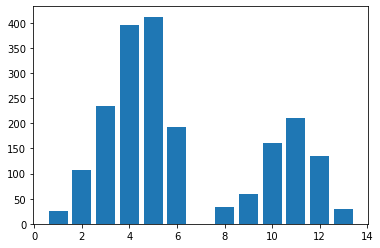

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] [26, 107, 234, 396, 412, 193, 0, 34, 59, 161, 210, 134, 30]


In [21]:
layerWidth = 768*2
layerDepth = 13
layers = [0] * layerDepth
layerIndex = list (range(1, layerDepth+1))
print (top_neurons)
for i in top_neurons:
    layerNum = int(i/layerWidth)
    layers[layerNum] = layers[layerNum] + 1

plt.bar(layerIndex, layers)
plt.show()

print (layerIndex, layers)
    
#for idx, val in enumerate(layers):
 #   print("Layer " + str(idx) + " contributes " + str(val))
    #print (val)


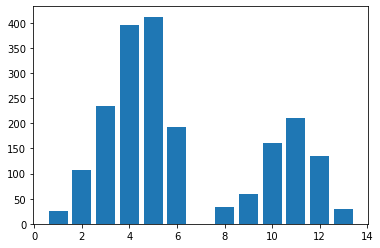

In [22]:
jsonList = {}
for i in range(0,len(layerIndex)):
    jsonList[layerIndex[i]] = layers[i]

f = open(layerWiseNeurons, 'w')
json.dump(jsonList, f)
f.close()

with open(layerWiseNeurons, 'r') as f:
   jsonList = json.load(f)

l = []
lIndex = []
for key in jsonList:
    lIndex.append(int(key))
    l.append(jsonList[key])

plt.bar(lIndex, l)
plt.show()

# Layer-wise Probe Accuracy (with retraining)

Selecting from Layer 1
768 13
Including neurons from f1(#0 to #768)
Including neurons from f1(#0 to #768)


11663it [00:01, 5948.07it/s]
1914it [00:00, 6512.26it/s]
3828it [00:00, 6678.23it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0082



Epoch: [2/5], Loss: 0.0060



Epoch: [3/5], Loss: 0.0056



Epoch: [4/5], Loss: 0.0054



Epoch: [5/5], Loss: 0.0053



Score (accuracy) of the model: 0.76
Selecting from Layer 2
768 13
Including neurons from f2(#768 to #1536)
Including neurons from f2(#768 to #1536)


11663it [00:01, 6017.19it/s]
1914it [00:00, 7424.84it/s]
3828it [00:00, 7439.77it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0071



Epoch: [2/5], Loss: 0.0055



Epoch: [3/5], Loss: 0.0052



Epoch: [4/5], Loss: 0.0050



Epoch: [5/5], Loss: 0.0049



Score (accuracy) of the model: 0.78
Selecting from Layer 3
768 13
Including neurons from f3(#1536 to #2304)
Including neurons from f3(#1536 to #2304)


11663it [00:01, 6163.09it/s]
1914it [00:00, 7376.22it/s]
3828it [00:00, 7391.86it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0056



Epoch: [2/5], Loss: 0.0038



Epoch: [3/5], Loss: 0.0034



Epoch: [4/5], Loss: 0.0032



Epoch: [5/5], Loss: 0.0031



Score (accuracy) of the model: 0.85
Selecting from Layer 4
768 13
Including neurons from f4(#2304 to #3072)
Including neurons from f4(#2304 to #3072)


11663it [00:01, 6376.42it/s]
1914it [00:00, 7451.76it/s]
3828it [00:00, 7414.93it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0044



Epoch: [2/5], Loss: 0.0028



Epoch: [3/5], Loss: 0.0025



Epoch: [4/5], Loss: 0.0023



Epoch: [5/5], Loss: 0.0022



Score (accuracy) of the model: 0.89
Selecting from Layer 5
768 13
Including neurons from f5(#3072 to #3840)
Including neurons from f5(#3072 to #3840)


11663it [00:01, 6496.31it/s]
1914it [00:00, 9218.74it/s]
3828it [00:00, 8131.98it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0039



Epoch: [2/5], Loss: 0.0022



Epoch: [3/5], Loss: 0.0019



Epoch: [4/5], Loss: 0.0018



Epoch: [5/5], Loss: 0.0016



Score (accuracy) of the model: 0.91
Selecting from Layer 6
768 13
Including neurons from f6(#3840 to #4608)
Including neurons from f6(#3840 to #4608)


11663it [00:01, 6815.67it/s]
1914it [00:00, 9305.01it/s]
3828it [00:00, 9179.45it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0034



Epoch: [2/5], Loss: 0.0018



Epoch: [3/5], Loss: 0.0015



Epoch: [4/5], Loss: 0.0014



Epoch: [5/5], Loss: 0.0013



Score (accuracy) of the model: 0.92
Selecting from Layer 7
768 13
Including neurons from f7(#4608 to #5376)
Including neurons from f7(#4608 to #5376)


11663it [00:01, 6505.21it/s]
1914it [00:00, 7850.94it/s]
3828it [00:00, 7714.50it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0032



Epoch: [2/5], Loss: 0.0016



Epoch: [3/5], Loss: 0.0013



Epoch: [4/5], Loss: 0.0012



Epoch: [5/5], Loss: 0.0011



Score (accuracy) of the model: 0.93
Selecting from Layer 8
768 13
Including neurons from f8(#5376 to #6144)
Including neurons from f8(#5376 to #6144)


11663it [00:01, 6096.79it/s]
1914it [00:00, 6897.35it/s]
3828it [00:00, 7340.33it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0032



Epoch: [2/5], Loss: 0.0016



Epoch: [3/5], Loss: 0.0013



Epoch: [4/5], Loss: 0.0012



Epoch: [5/5], Loss: 0.0010



Score (accuracy) of the model: 0.93
Selecting from Layer 9
768 13
Including neurons from f9(#6144 to #6912)
Including neurons from f9(#6144 to #6912)


11663it [00:01, 6595.38it/s]
1914it [00:00, 9357.85it/s]
3828it [00:00, 9202.38it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0032



Epoch: [2/5], Loss: 0.0015



Epoch: [3/5], Loss: 0.0013



Epoch: [4/5], Loss: 0.0011



Epoch: [5/5], Loss: 0.0010



Score (accuracy) of the model: 0.94
Selecting from Layer 10
768 13
Including neurons from f10(#6912 to #7680)
Including neurons from f10(#6912 to #7680)


11663it [00:02, 5682.93it/s]
1914it [00:00, 6179.14it/s]
3828it [00:00, 6108.86it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0033



Epoch: [2/5], Loss: 0.0016



Epoch: [3/5], Loss: 0.0013



Epoch: [4/5], Loss: 0.0012



Epoch: [5/5], Loss: 0.0011



Score (accuracy) of the model: 0.93
Selecting from Layer 11
768 13
Including neurons from f11(#7680 to #8448)
Including neurons from f11(#7680 to #8448)


11663it [00:01, 6957.97it/s]
1914it [00:00, 8167.59it/s]
3828it [00:00, 8728.54it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0036



Epoch: [2/5], Loss: 0.0018



Epoch: [3/5], Loss: 0.0015



Epoch: [4/5], Loss: 0.0013



Epoch: [5/5], Loss: 0.0012



Score (accuracy) of the model: 0.93
Selecting from Layer 12
768 13
Including neurons from f12(#8448 to #9216)
Including neurons from f12(#8448 to #9216)


11663it [00:01, 7368.49it/s]
1914it [00:00, 9422.01it/s]
3828it [00:00, 8703.01it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0040



Epoch: [2/5], Loss: 0.0020



Epoch: [3/5], Loss: 0.0017



Epoch: [4/5], Loss: 0.0015



Epoch: [5/5], Loss: 0.0014



Score (accuracy) of the model: 0.93
Selecting from Layer 13
768 13
Including neurons from f13(#9216 to #9984)
Including neurons from f13(#9216 to #9984)


11663it [00:01, 7073.28it/s]
1914it [00:00, 10135.27it/s]
3828it [00:00, 9940.38it/s]


Creating train tensors...
Number of tokens:  198800
length of source dictionary:  19554
length of target dictionary:  49
198800
Total instances: 198800
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'tin', 'Norwegians', 'relatively', 'integrate', 'tele', 'gaps', 'Atal', 'Lamonica', 'Kaufman', 'substantiation', 'sofa', 'woollies', 'Town', 'pendulum', 'operation']
Number of tokens:  24904
length of source dictionary:  19554
length of target dictionary:  49
24904
Total instances: 24904
['Shuttle', 'reason', 'academic', 'Afghanistan', 'Barrel', 'grammar', 'Bonding', 'suburban', 'intrepid', 'vu', 'operation', 'awful', 'darin', 'ones', 'runner', 'weight', 'Prime', 'unsure', 'arabes', 'comme']
Number of tokens:  49464
length of source dictionary:  19554
length of target dictionary:  49
49464
Total instances: 49464
['Shuttle', 'deals', 'reason', 'Afghanistan', 'academic', 'spoiler', 'Barrel', 'grammar', 'relatively', 'Bonding', 'suburban', 'intrepid', 'Atal', 'pepco', 'vu', 'Town', 


Epoch: [1/5], Loss: 0.0082



Epoch: [2/5], Loss: 0.0037



Epoch: [3/5], Loss: 0.0029



Epoch: [4/5], Loss: 0.0025



Epoch: [5/5], Loss: 0.0023



Score (accuracy) of the model: 0.91


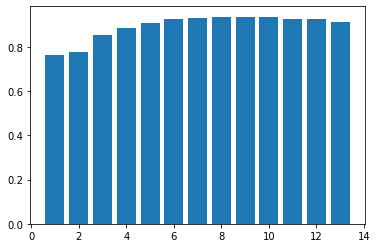

In [23]:
layerAccuracy = [0] * layerDepth
layerIndex = list (range(1, layerDepth+1))


for layer in range(1, NUM_LAYERS+1):
    
    print ("Selecting from Layer " + str(layer))
    filter_layers="f" + str(layer)
    print(NUM_NEURONS_PER_LAYER, NUM_LAYERS)
    f_train_activations, f_test_activations = utils.filter_activations_by_layers(train_activations, test_activations, filter_layers, NUM_NEURONS_PER_LAYER, NUM_LAYERS, IS_BRNN)
    f_train_activations, f_dev_activations = utils.filter_activations_by_layers(train_activations, dev_activations, filter_layers, NUM_NEURONS_PER_LAYER, NUM_LAYERS, IS_BRNN)
    
    ff_train_activations = concatenateActivations(f_train_activations, train_tokens)
    ff_dev_activations = concatenateActivations(f_dev_activations, dev_tokens)
    ff_test_activations = concatenateActivations(f_test_activations, test_tokens)
    
    #ff_train_activations = f_train_activations
    #ff_dev_activations = f_dev_activations
    #ff_test_activations = f_test_activations

    

    print("Creating train tensors...")
    X_filtered, y, mappings = utils.create_tensors(train_tokens, ff_train_activations, TASK_SPECIFIC_TAG)
    X_dev_filtered, y_dev, mappings = utils.create_tensors(dev_tokens, ff_dev_activations, TASK_SPECIFIC_TAG, mappings)
    X_test_filtered, y_test, mappings = utils.create_tensors(test_tokens, ff_test_activations, TASK_SPECIFIC_TAG, mappings)
    label2idx, idx2label, src2idx, idx2src = mappings
    
    print("Building model...")
    
    model_filtered = utils.train_logreg_model(X_filtered, y, lambda_l1=0, lambda_l2=0, num_epochs=5, batch_size=BATCH_SIZE)
    #overall_train_accuracies = utils.evaluate_model(model_filtered, X_filtered, y, idx2label)
    #overall_dev_accuracies = utils.evaluate_model(model_filtered, X_dev_filtered, y_dev, idx2label)
    overall_test_accuracies, predictions = utils.evaluate_model(model_filtered, X_test_filtered, y_test, idx2label, return_predictions=True, source_tokens=test_tokens['source'])
    layerAccuracy[layer-1] = overall_test_accuracies['__OVERALL__']
    
plt.bar(layerIndex, layerAccuracy)
plt.show()

[0.7628376192786673, 0.7777979945010512, 0.8540150412421155, 0.8857755135047711, 0.9075084910237748, 0.9241872877244056, 0.9317887756752385, 0.9348010674429889, 0.9359938541161249, 0.9339317483422287, 0.9276443474041728, 0.9261685266052079, 0.9102983988355168]


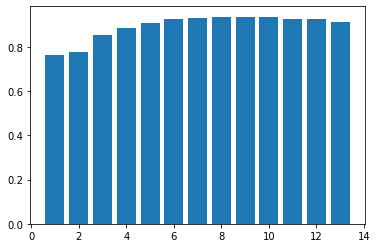

In [24]:
jsonList = {}
for i in range(0,len(layerIndex)):
    jsonList[layerIndex[i]] = layerAccuracy[i]

f = open(layerWiseAccuracy, 'w')
json.dump(jsonList, f)
f.close()

with open(layerWiseAccuracy, 'r') as f:
   jsonList = json.load(f)

lAcc = []
lIndex = []
for key in jsonList:
    lIndex.append(int(key))
    lAcc.append(jsonList[key])

print (lAcc)
plt.bar(lIndex, lAcc)
plt.show()

# Spread of Neurons per property

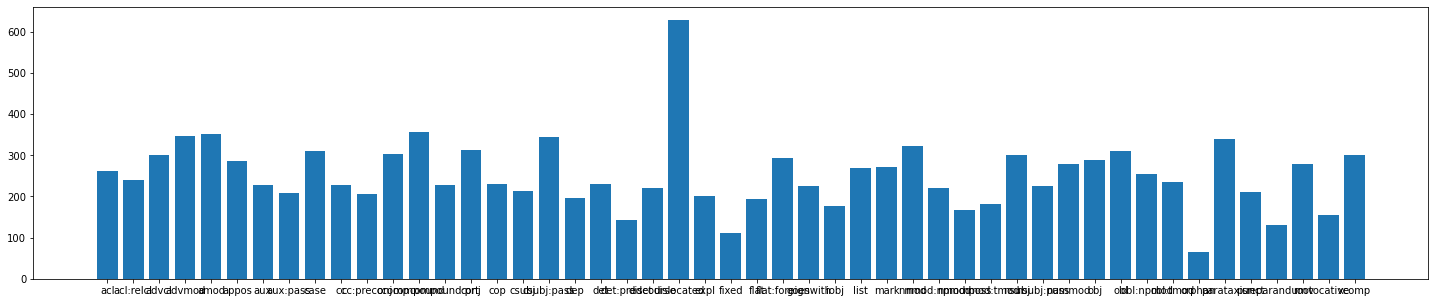

In [25]:
properties = []
numNeurons = []

for k, v in classWise.items():
    #print (k, v)
    properties.append(k)
    numNeurons.append(len(v))

properties, numNeurons = zip(*sorted(zip(properties, numNeurons)))
plt.figure(figsize=(25,5))
plt.bar(properties, numNeurons)
plt.show()

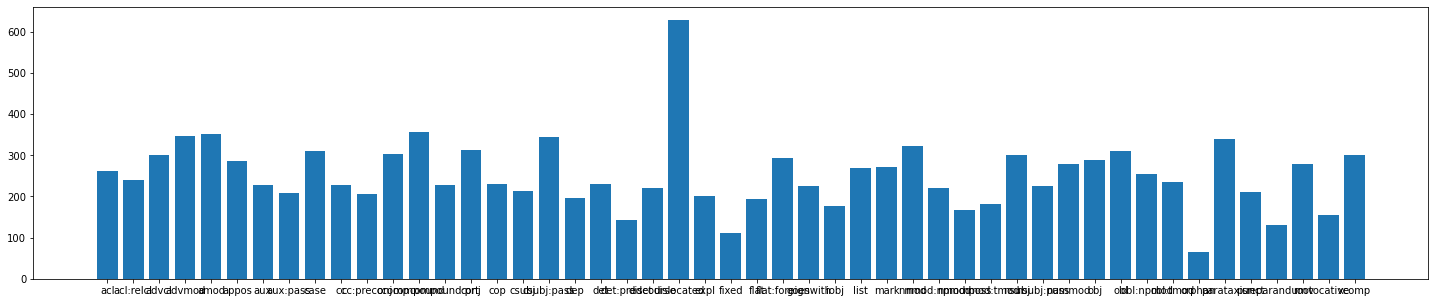

In [26]:
jsonList = {}
for i in range(0,len(properties)):
    jsonList[properties[i]] = numNeurons[i]

f = open(spreadOfNeurons, 'w')
json.dump(jsonList, f)
f.close()

with open(spreadOfNeurons, 'r') as f:
   jsonList = json.load(f)

p = []
numN = []
for key in jsonList:
    p.append(key)
    numN.append(jsonList[key])
    
plt.figure(figsize=(25,5))
plt.bar(p, numN)
plt.show()

# Spread of Neurons per layer per property

acl


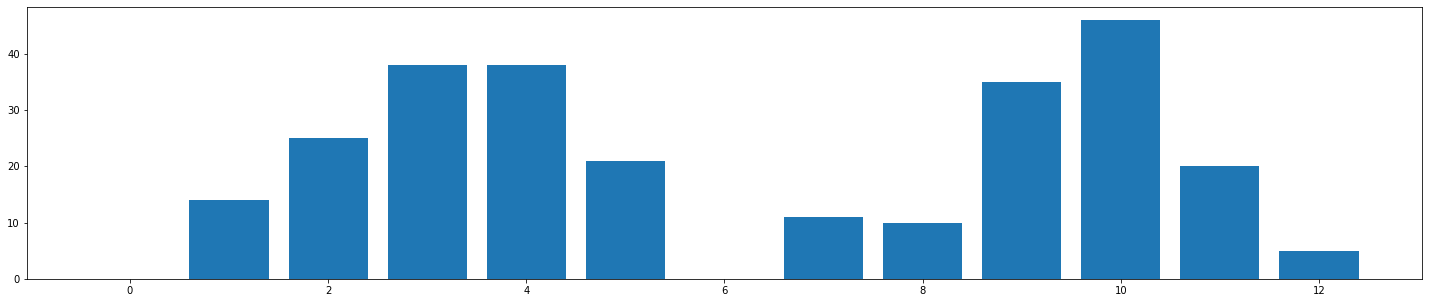

acl:relcl


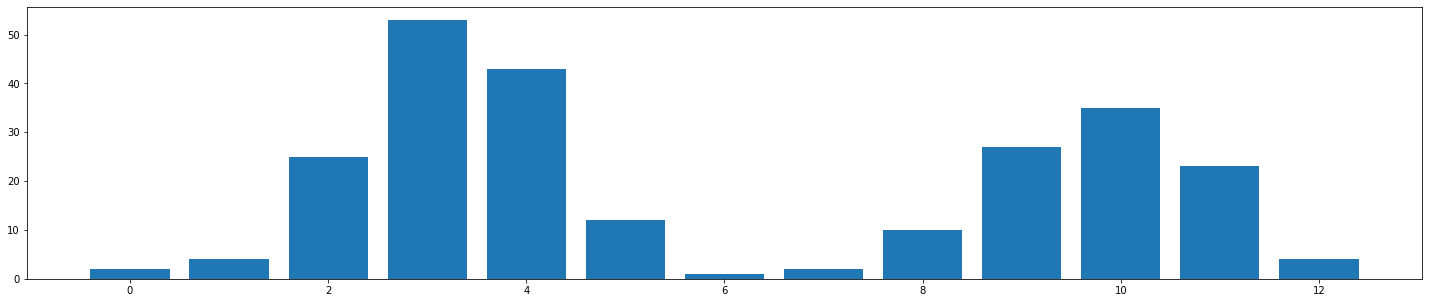

advcl


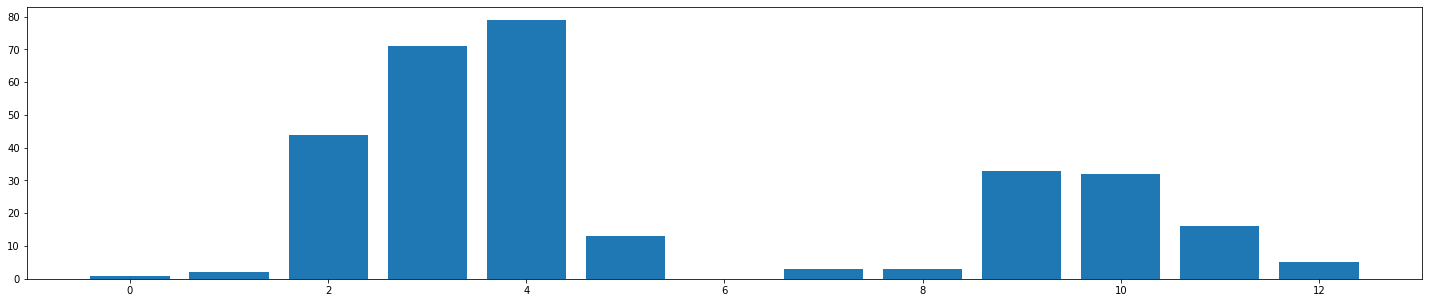

advmod


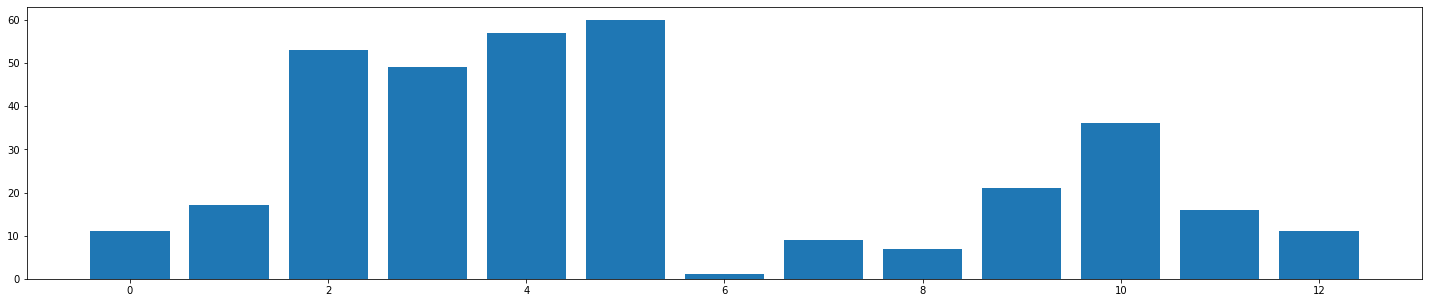

amod


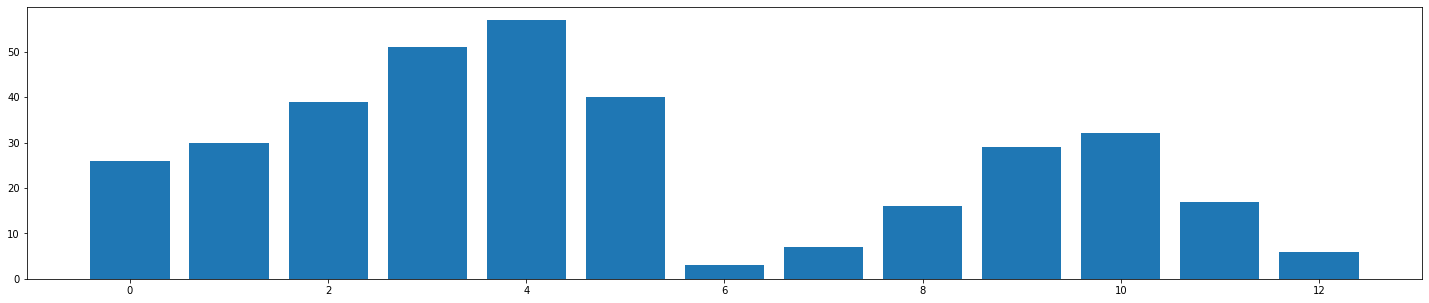

appos


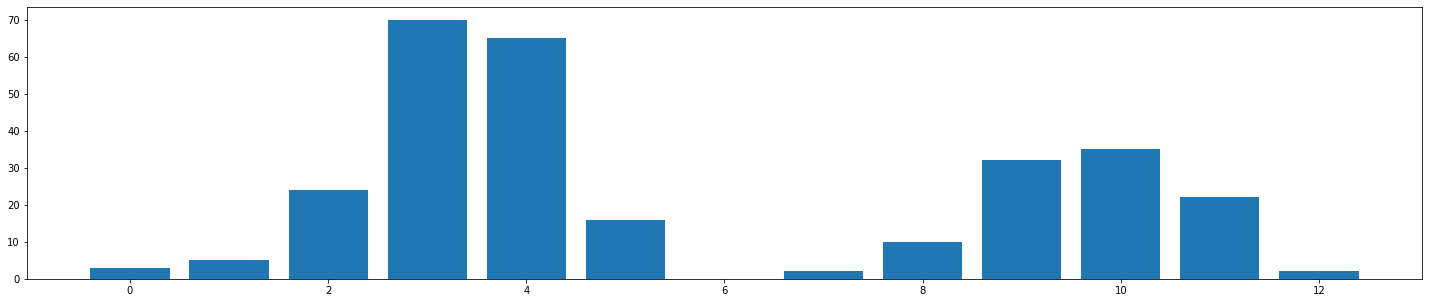

aux


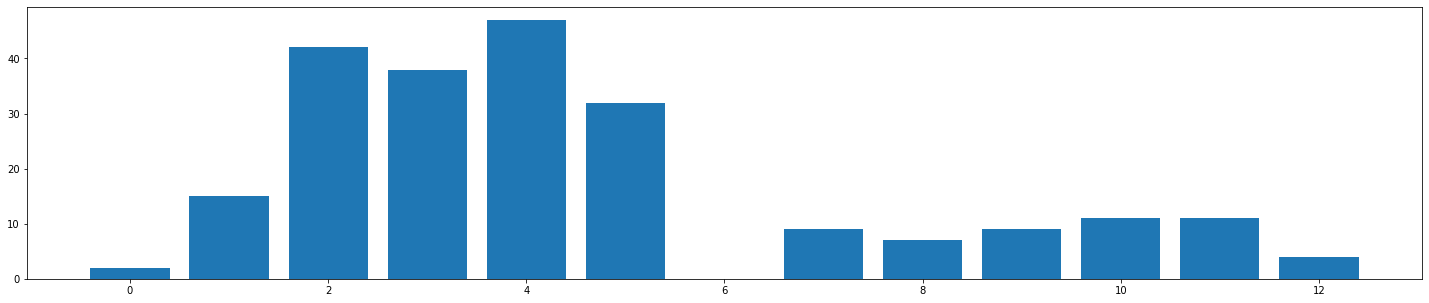

aux:pass


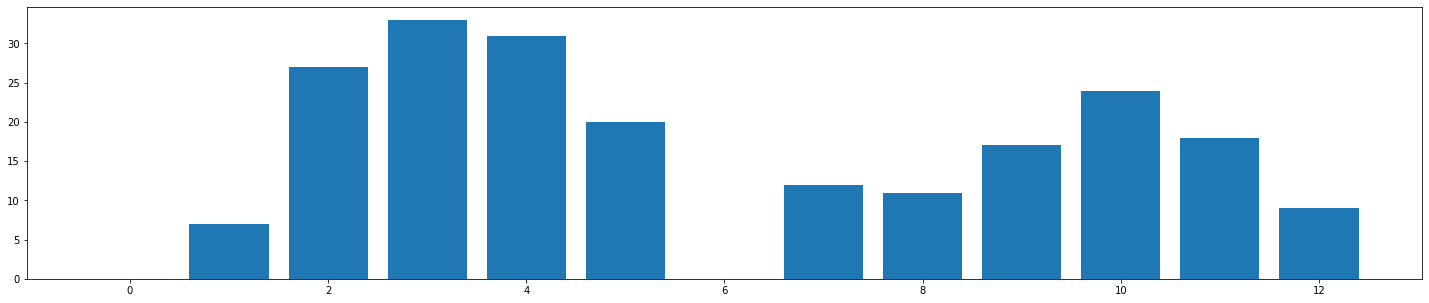

case


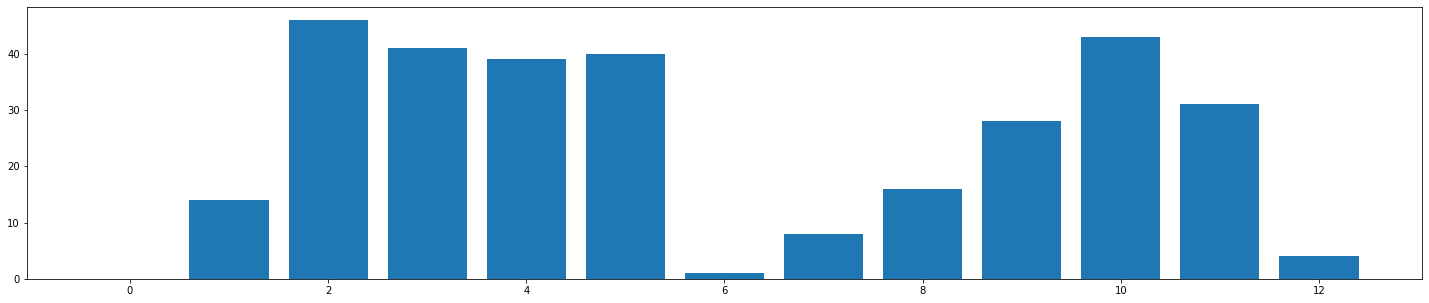

cc


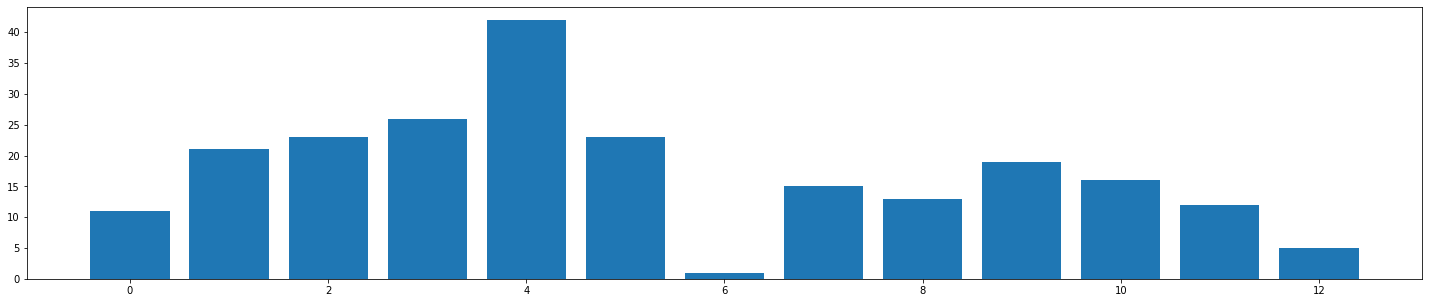

cc:preconj


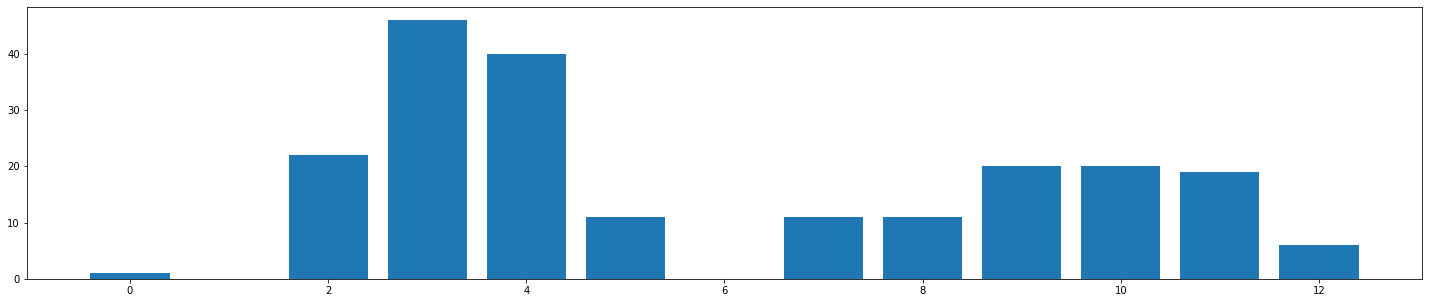

ccomp


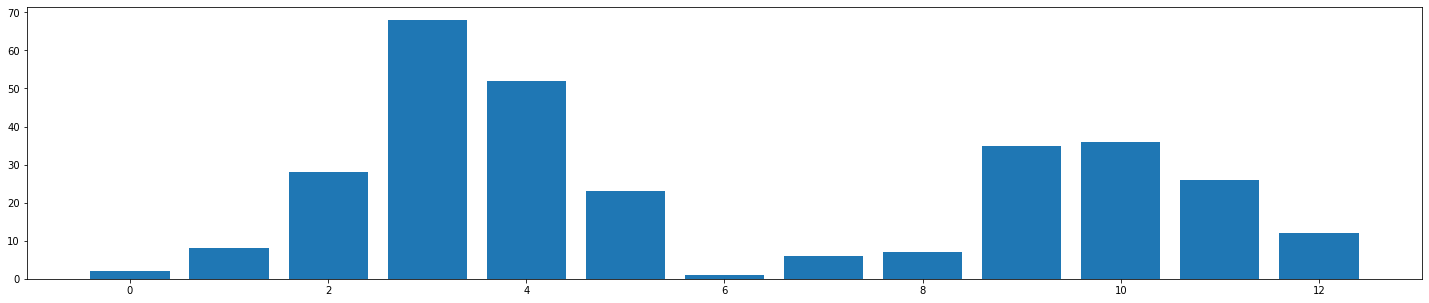

compound


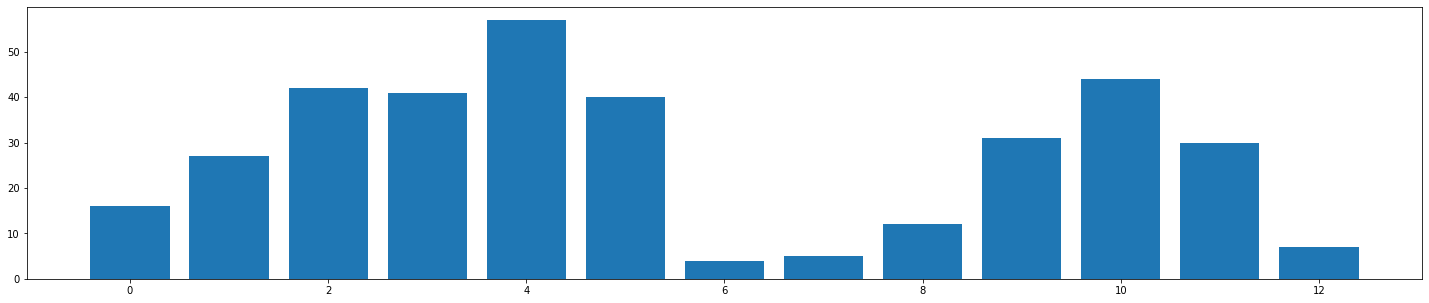

compound:prt


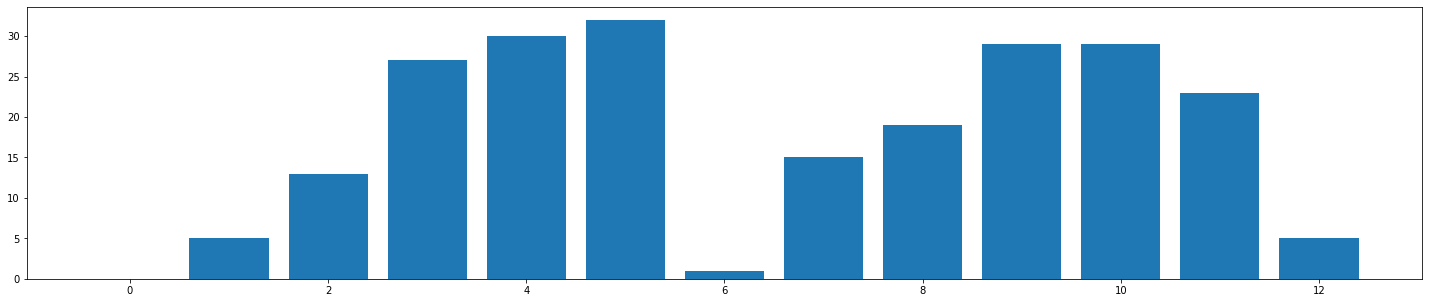

conj


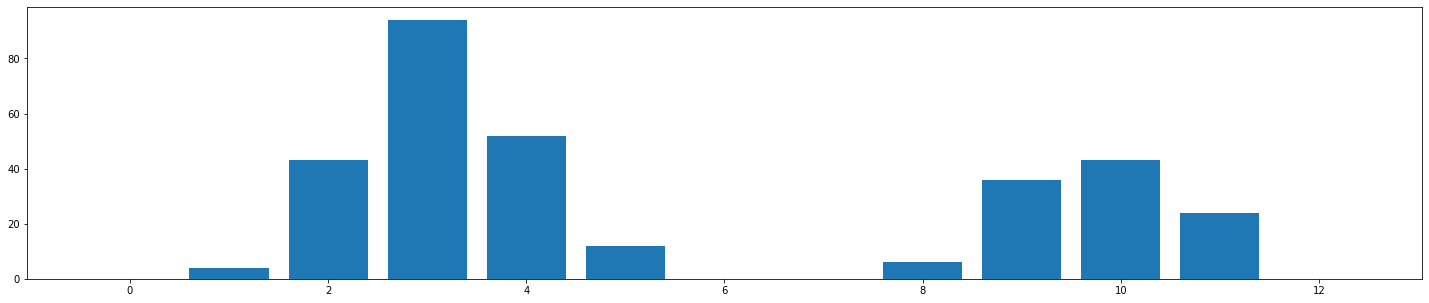

cop


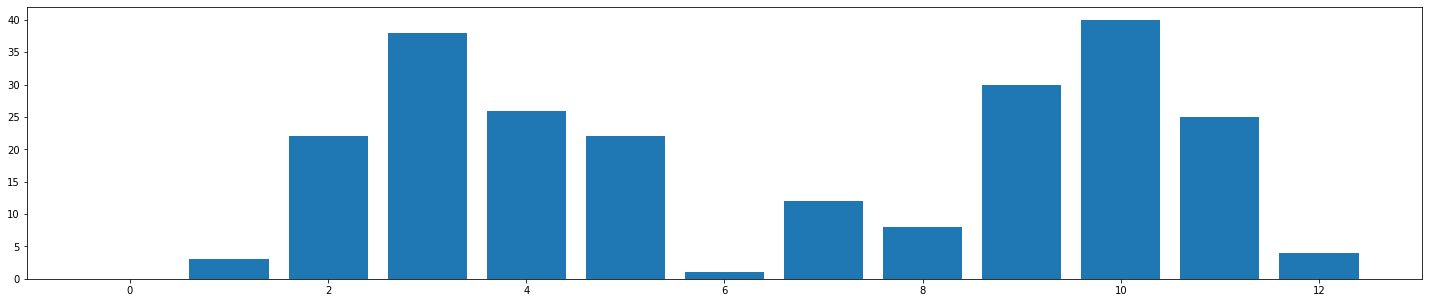

csubj


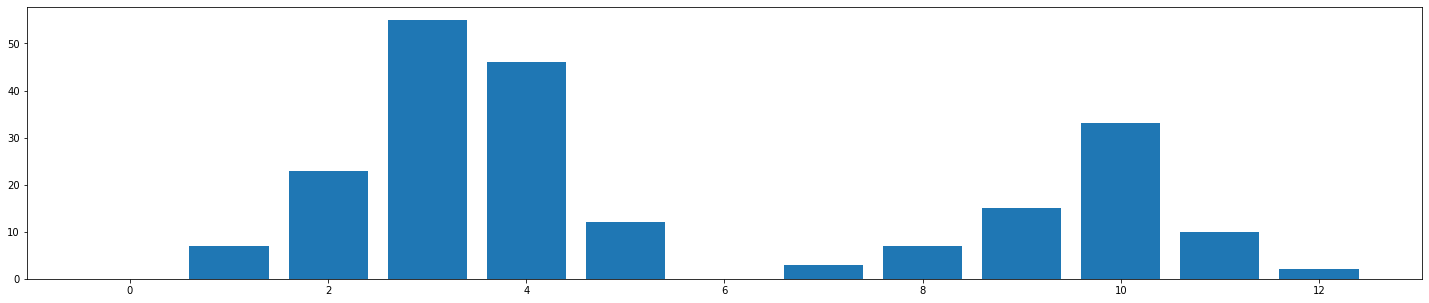

csubj:pass


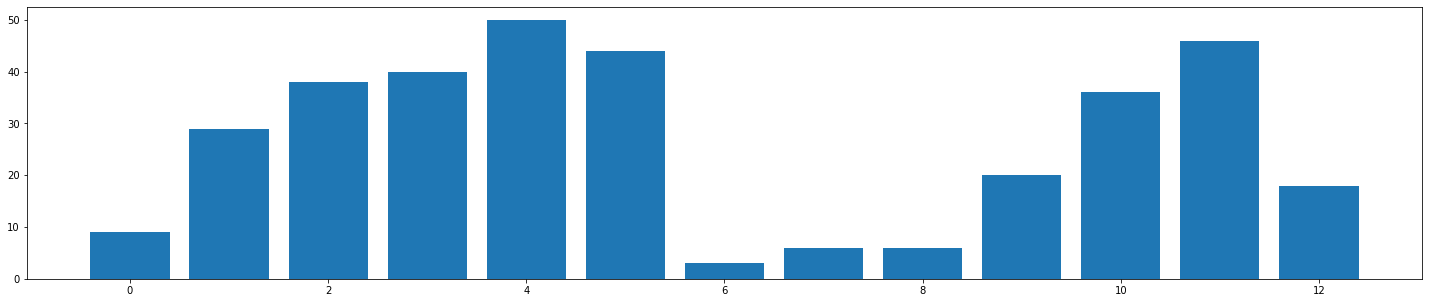

dep


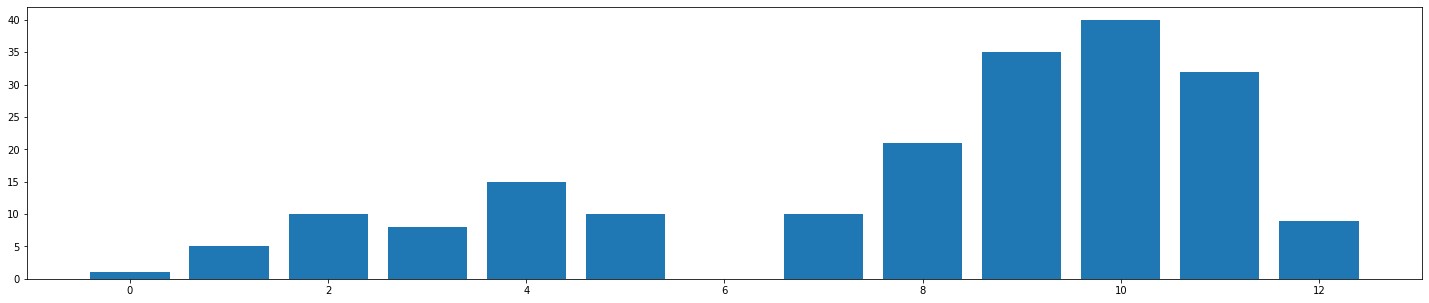

det


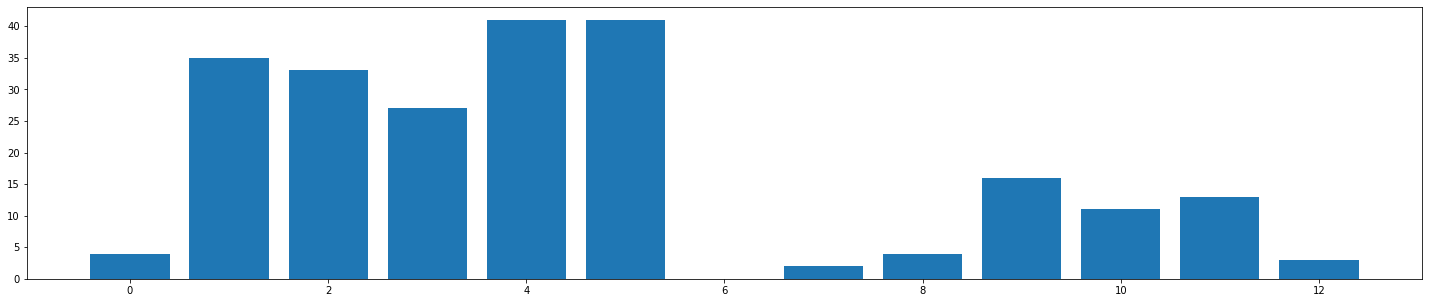

det:predet


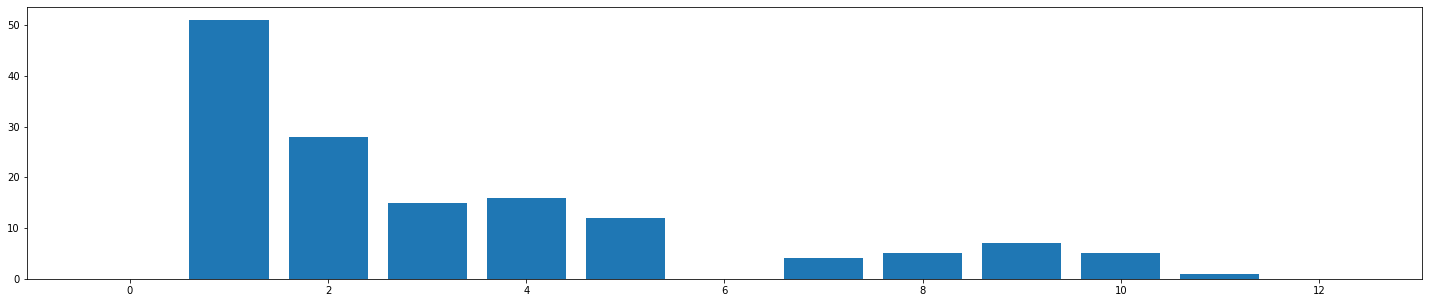

discourse


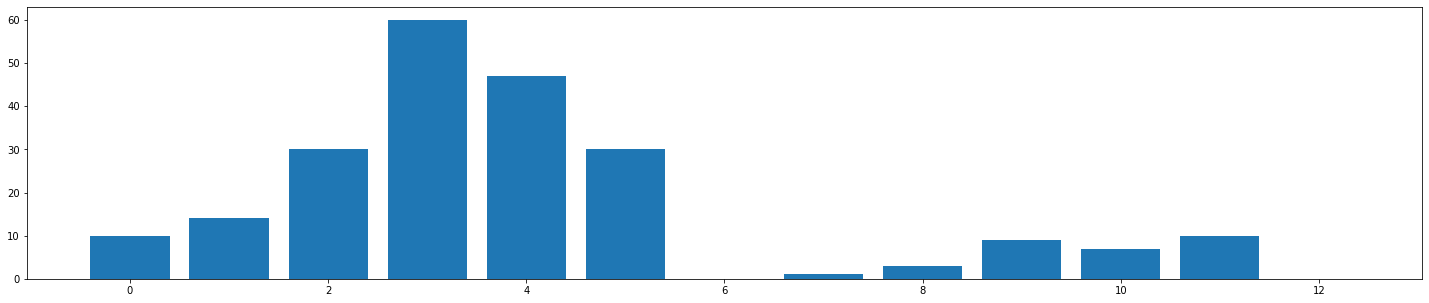

dislocated


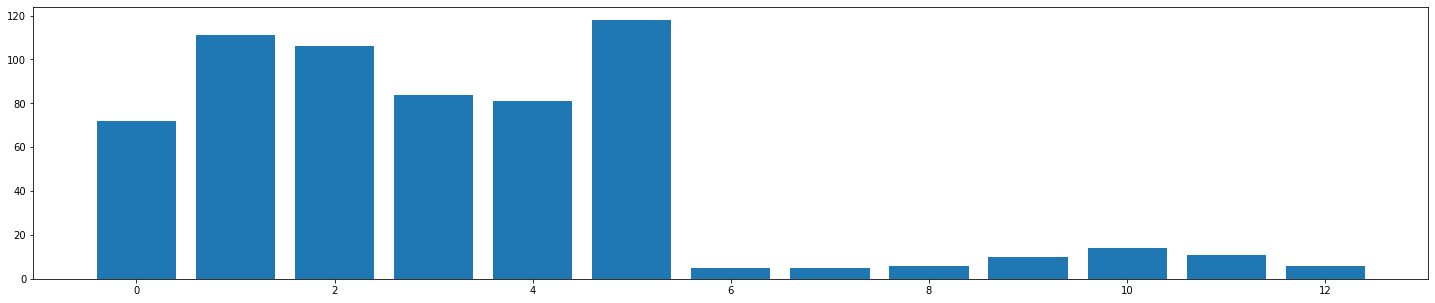

expl


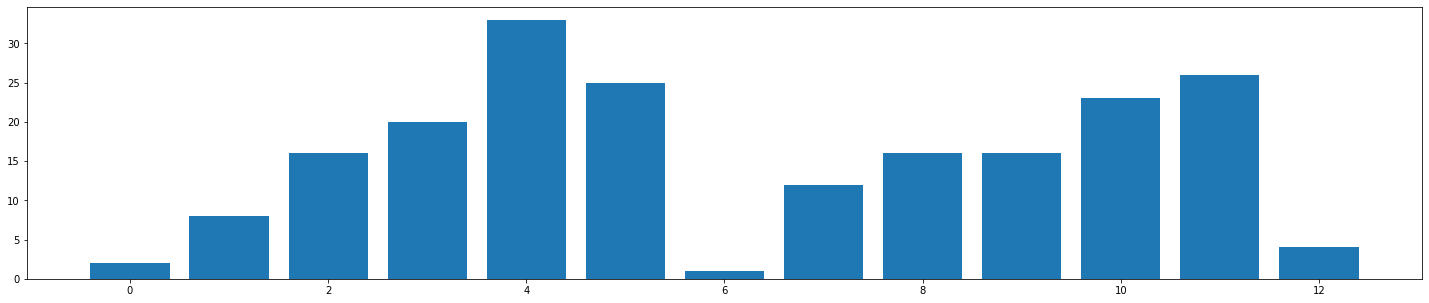

fixed


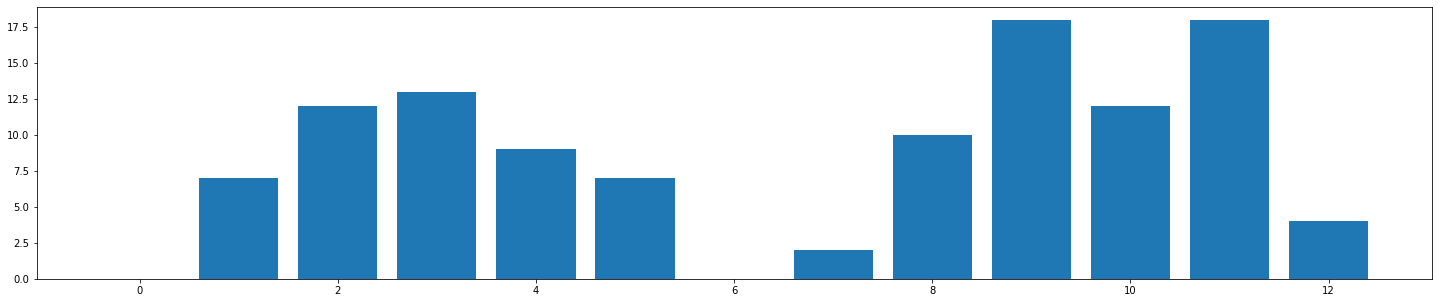

flat


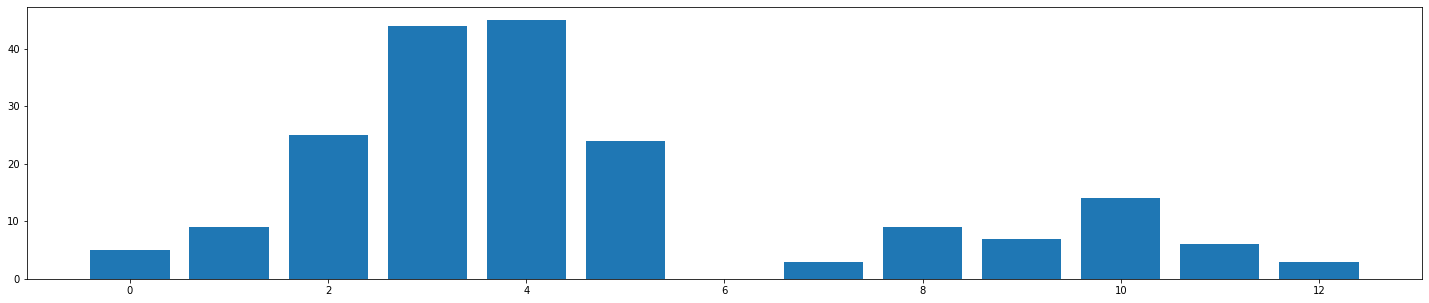

flat:foreign


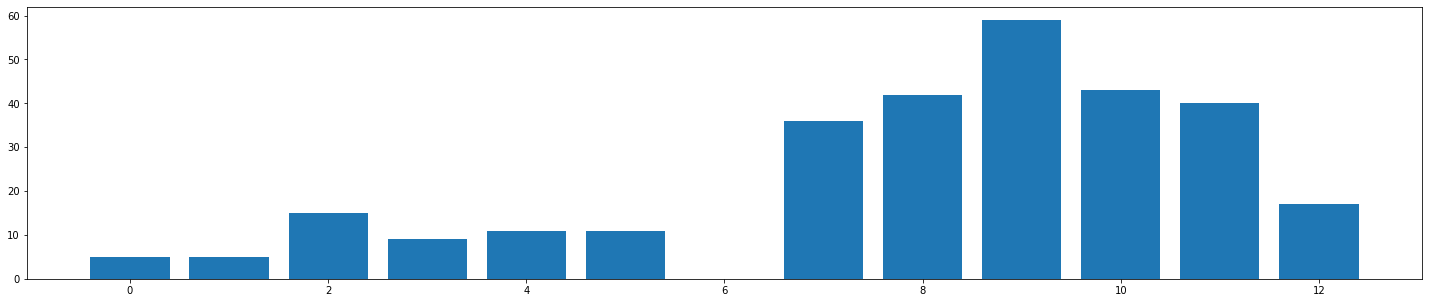

goeswith


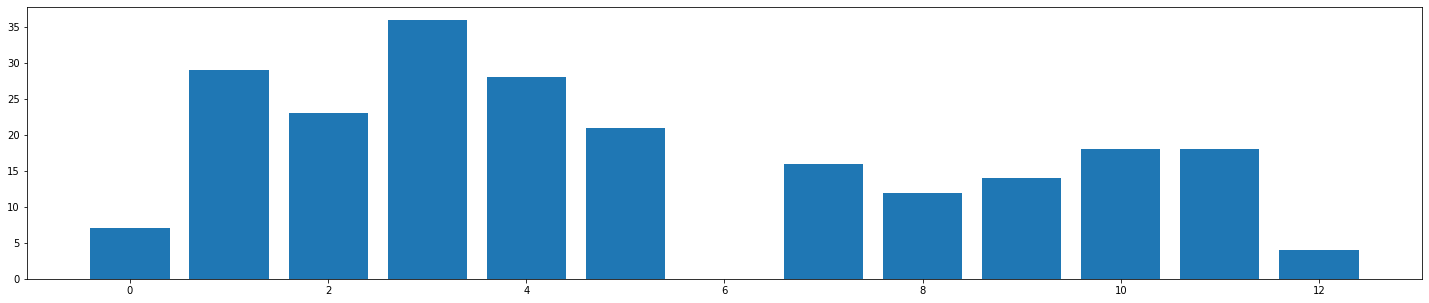

iobj


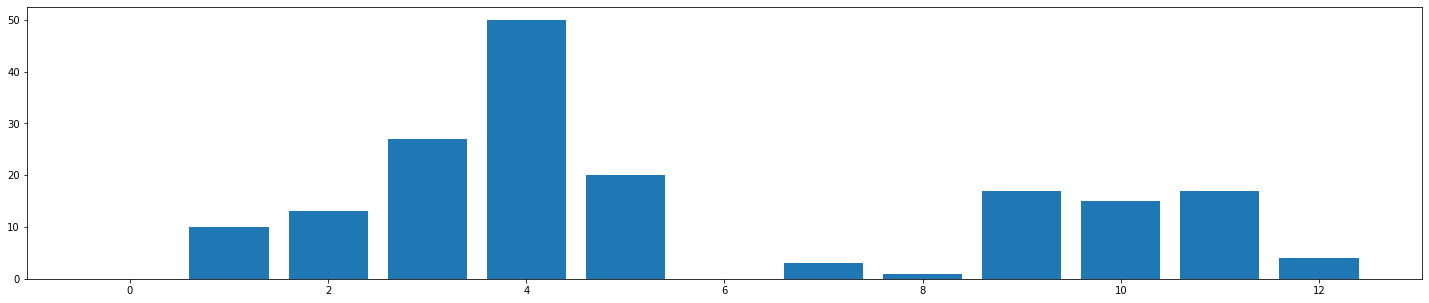

list


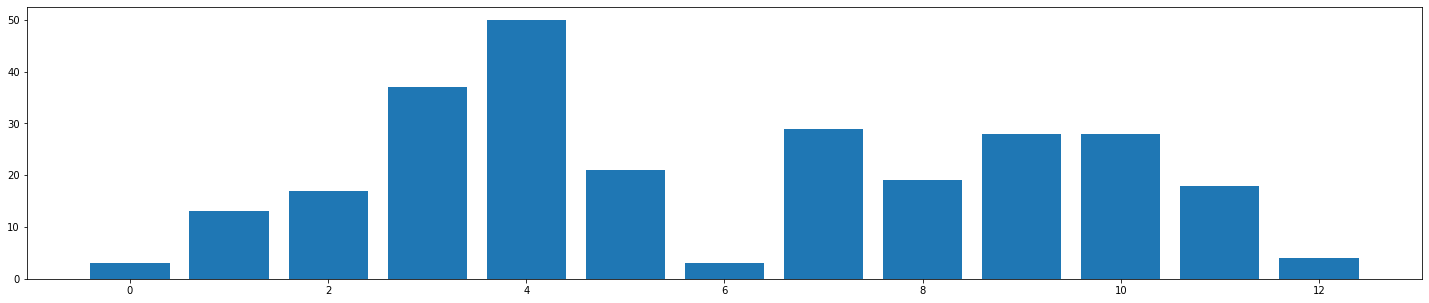

mark


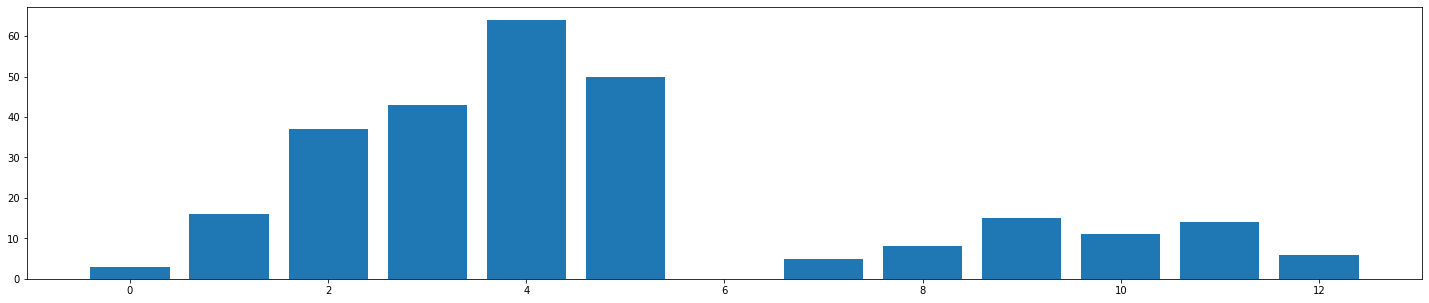

nmod


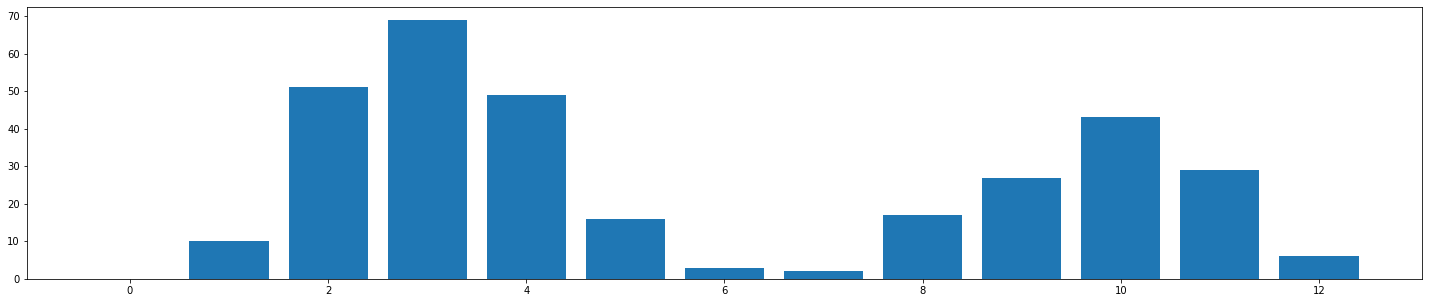

nmod:npmod


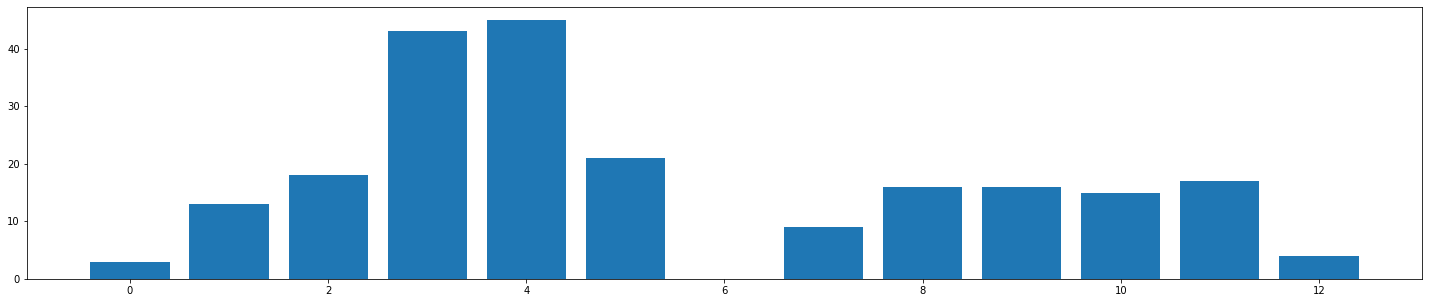

nmod:poss


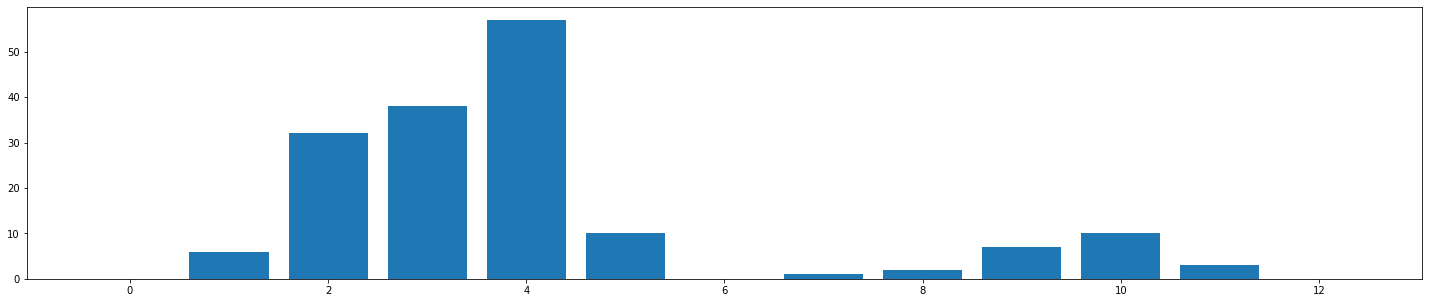

nmod:tmod


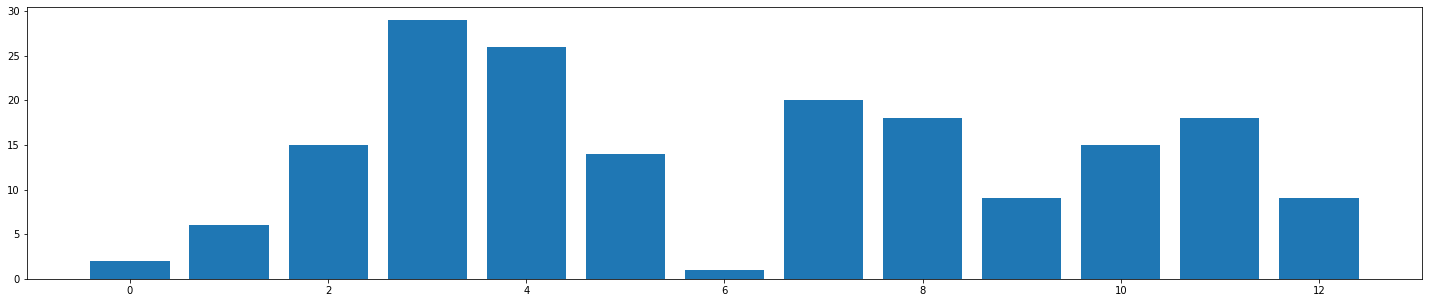

nsubj


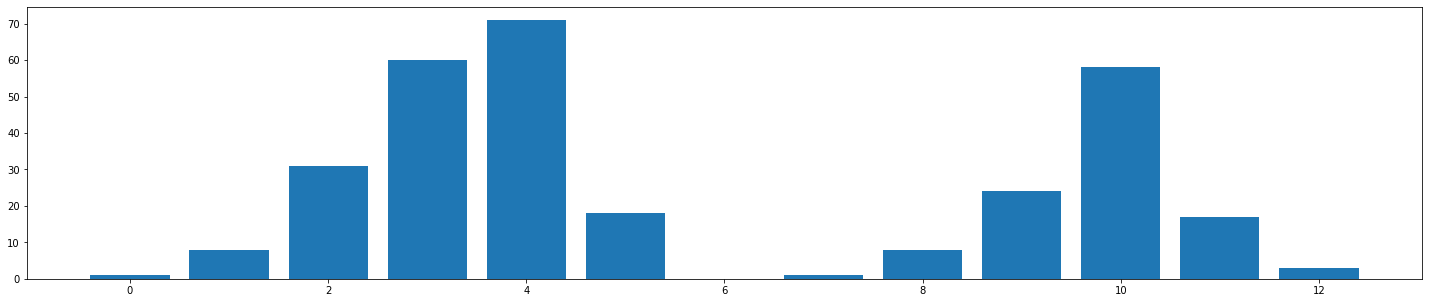

nsubj:pass


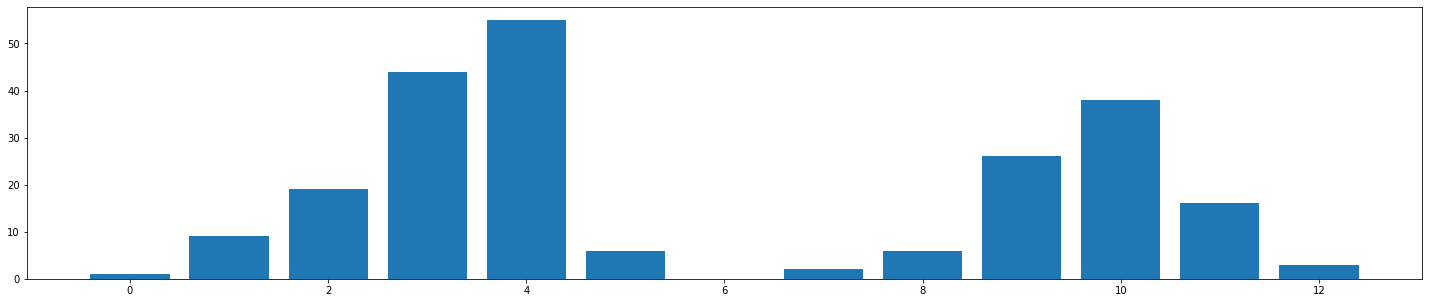

nummod


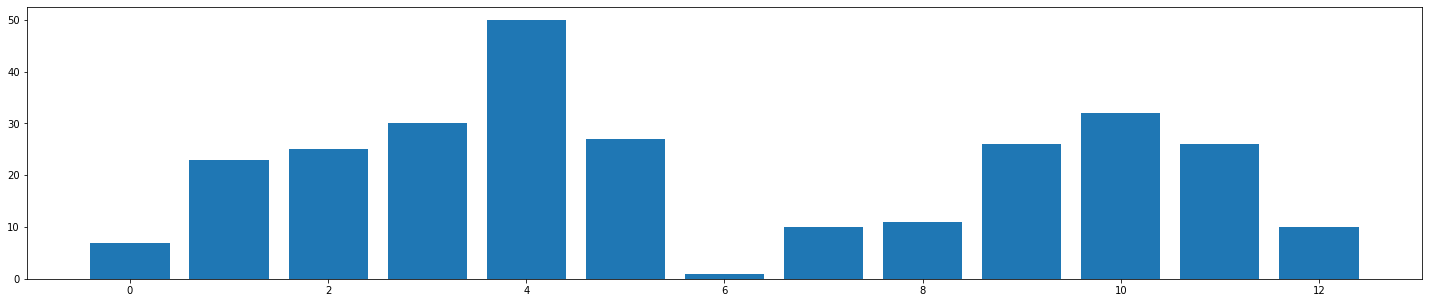

obj


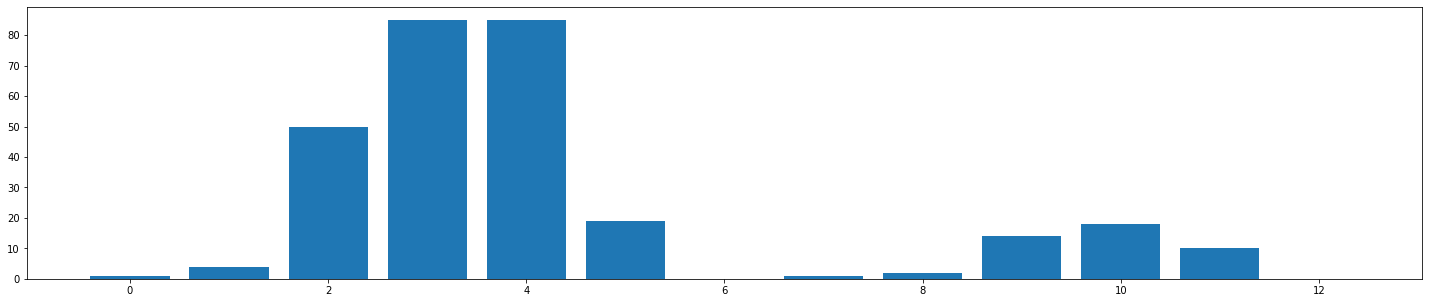

obl


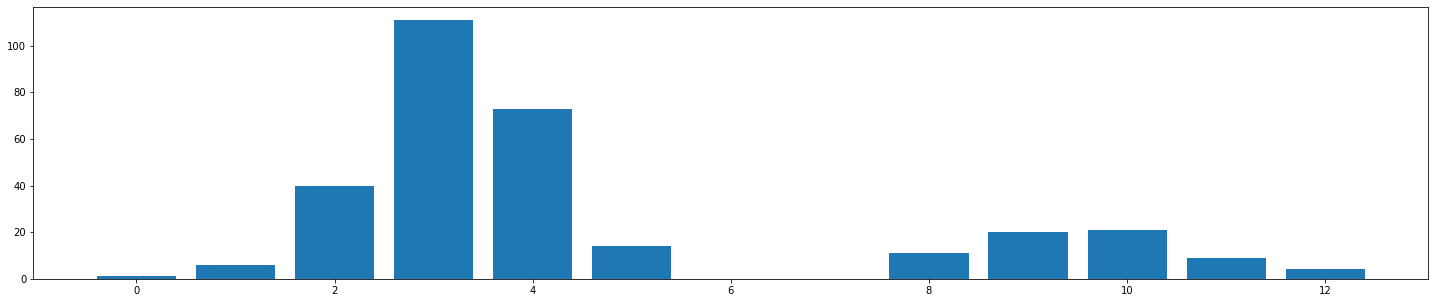

obl:npmod


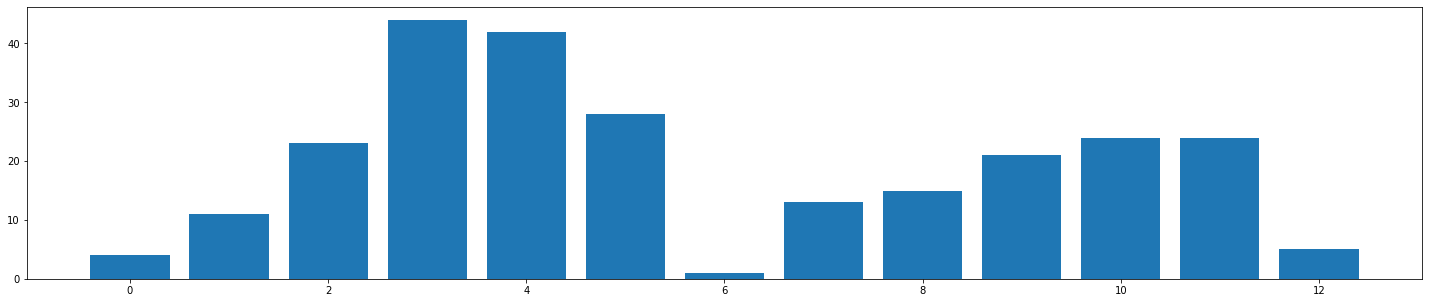

obl:tmod


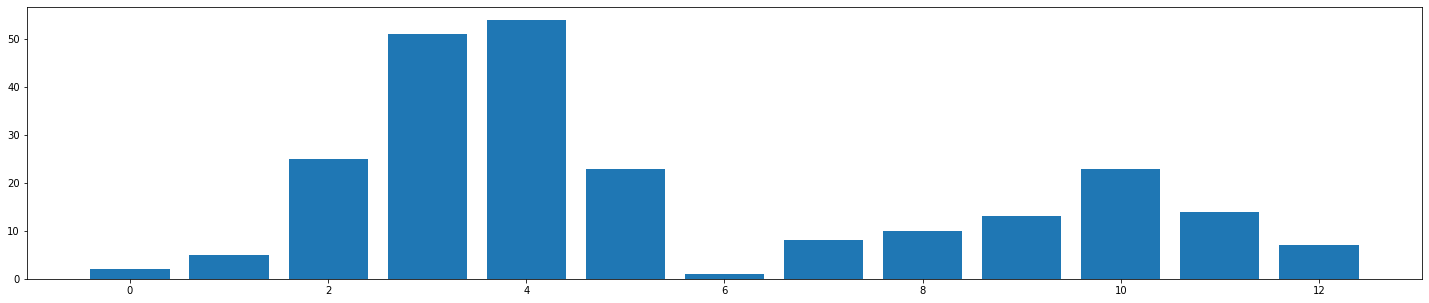

orphan


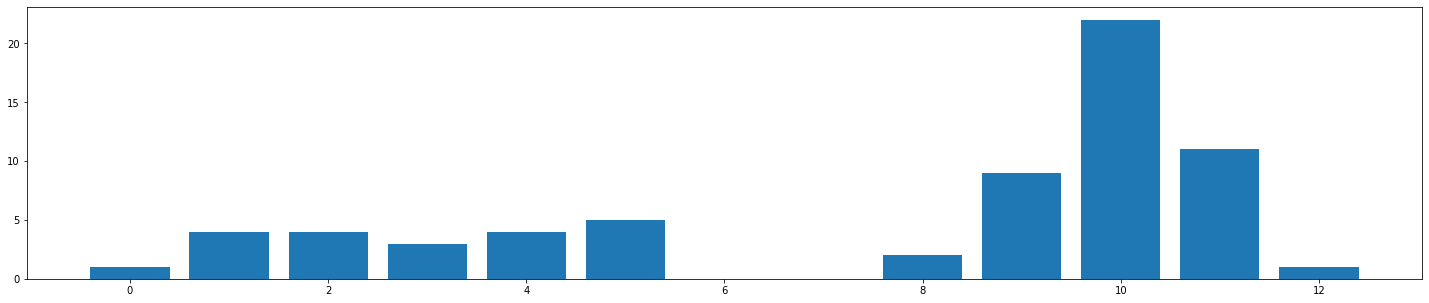

parataxis


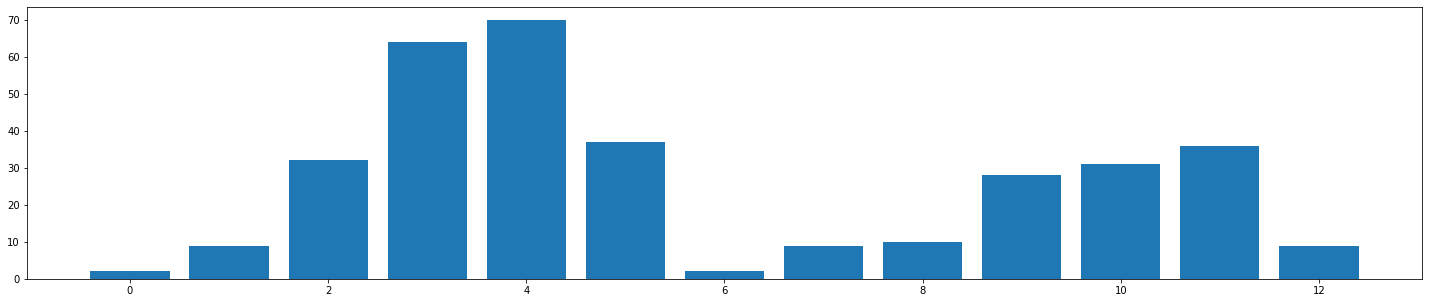

punct


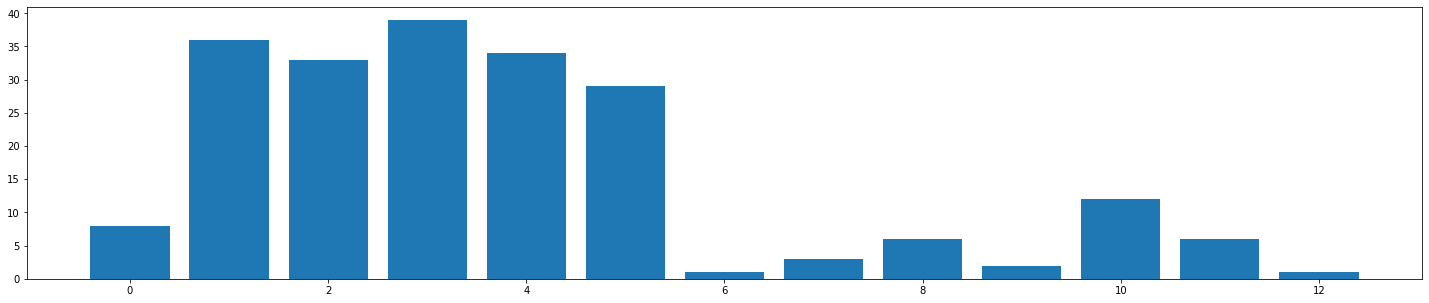

reparandum


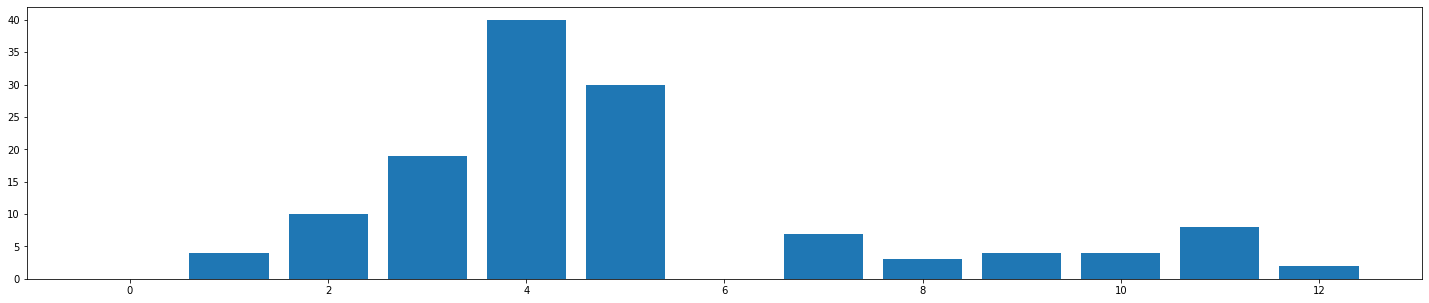

root


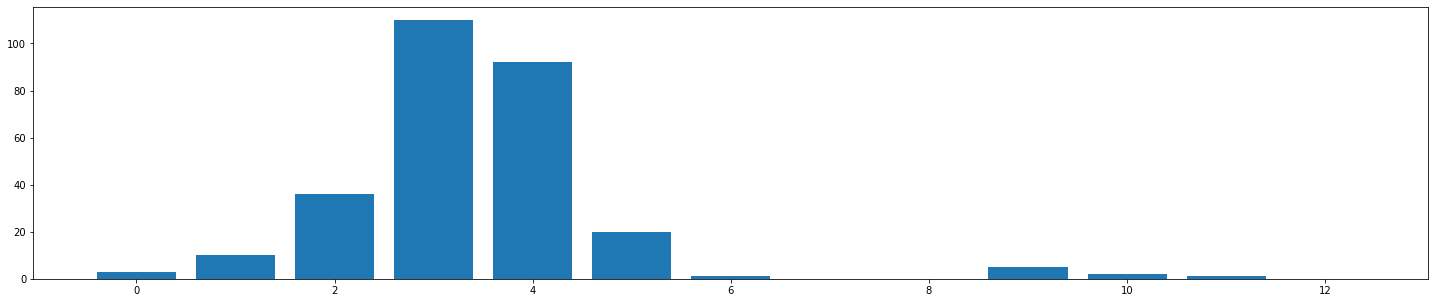

vocative


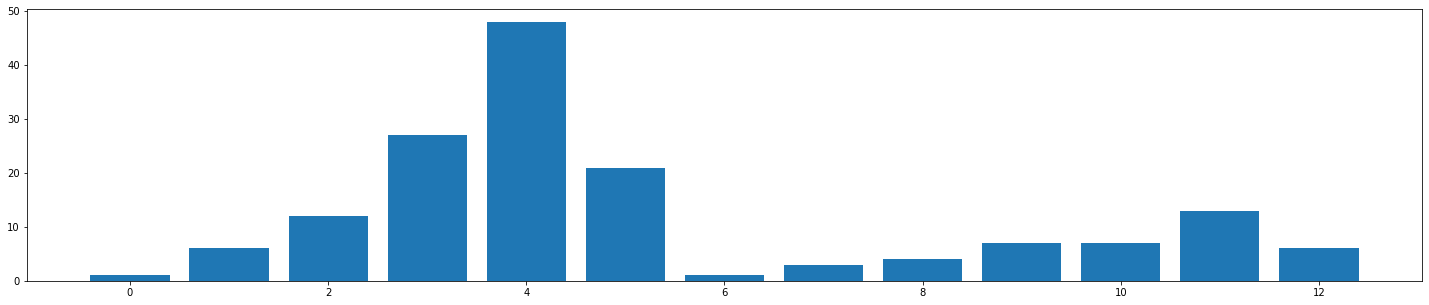

xcomp


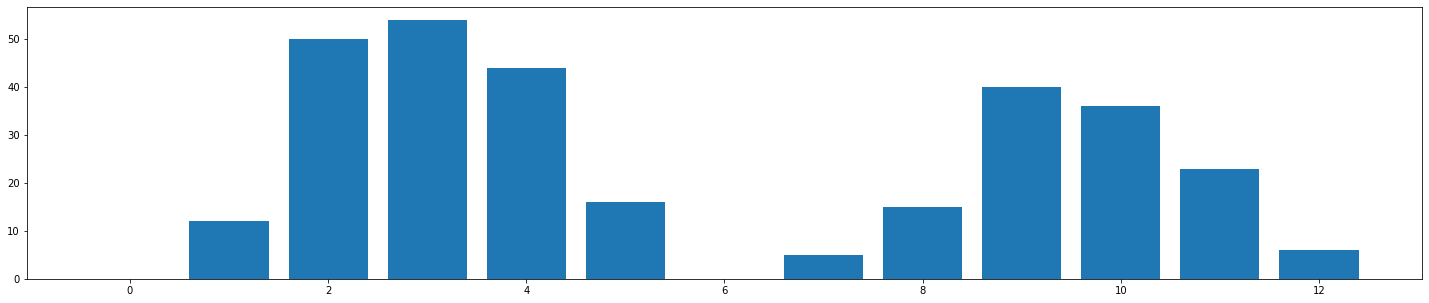

In [27]:
layerWidth = 768*2
layerDepth = 13
winner = list (range(0, layerDepth))

top_neurons = collections.OrderedDict(sorted(classWise.items()))

for k, v in top_neurons.items():
    layers = [0] * layerDepth
    for i in v:
        layerNum = int(i/layerWidth)
        layers[layerNum] = layers[layerNum] + 1
    
    print (k)
    plt.figure(figsize=(25,5))
    plt.bar(winner, layers)
    plt.show()
    


   

In [28]:
jsonList = {}
top_neurons = collections.OrderedDict(sorted(classWise.items()))

for k, v in top_neurons.items():
    vv = [int(x) for x in v]
    jsonList[k] = vv
    
f = open(spreadOfNeuronsPropertyWise, 'w')
json.dump(jsonList, f)
f.close()
    

In [29]:
layerWidth = 768
layerDepth = 13
winner = [0] * layerDepth


for k, v in classWise.items():
    layers = [0] * layerDepth
    for i in v:
        layerNum = int(i/layerWidth)
        layers[layerNum] = layers[layerNum] + 1
    
    max = 0
    maxVal = 0
    print (k, end = ',' )
    
    for idx, val in enumerate(layers):
        print(val , end = ','),
        if (val > maxVal):
            max = idx
            maxVal = val
    winner[max] = winner[max] +1
    print (max, '\n')

print ("Winner", end = ',')
for i, j in enumerate (winner):
    print (j, end = ',')

IndexError: list index out of range

# Neuron to Property Map

In [ ]:
percentage=0.05
ordering, cutoffs = utils.get_neuron_ordering(model, label2idx, search_stride=1000)
top_neurons_global = ordering[:int(percentage*len(ordering))]
fac = 1
top_neurons_local = []

while (len(top_neurons_local) < len(top_neurons_global)):
    top_neurons_local, classWise = utils.get_top_neurons(model, percentage*fac, label2idx)
    fac = fac + 0.1


top_neurons_l = set()
top_neurons_g = set()

layerWidth = 768
layerDepth = 13
neuronMap = {}

for i in top_neurons_global:
    top_neurons_g.add(i)

print (len(ordering), len(top_neurons_global), len(top_neurons_local))
for k, v in classWise.items():
    print (k, len(v))
    for i in v:
        propertyList = []
        if i in neuronMap.keys():
            propertyList = neuronMap[i]
        propertyList.append(str(k))
        neuronMap[int(i)] = propertyList
        top_neurons_l.add(i)

result = top_neurons_g.intersection(top_neurons_l)
print (result, len(result))

with open(nMap, 'w') as fp:
        json.dump(neuronMap, fp)

        ############################## Loading the dictionary ####################
        
with open(nMap, 'r') as fp:
   neuronMap = json.load(fp)
        
for key in neuronMap:
    propertyList =  neuronMap[key]
    print (key, end = '\t')
    for i in propertyList:
        print (i , end = '\t')
    print ()
